In [2]:
import os
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.backends.backend_pdf

### There are two files that data is extracted from:
1. split_CRDM_analysis_Environment where I take the participants data from split_CRDM_analysis and incorporate envrionment (home/lab) of the session
2. Confidence folder where I take the participant crdm_SV_hat_combined_hat csv in the utility folder created from the IDM model and rename it to reflect the environment (home/lab) of the session

EXAMPLES are in the utility folder on the OneDrive

In [3]:
sdm_crdm = pd.read_csv('/content/split_CRDM_analysis_Environment.csv')

In [4]:
sdm_crdm.head()

,Unnamed: 0,subject,task,domain,response_rate,percent_lottery,percent_risk,percent_ambiguity,conf_1,conf_2,...,alpha,at_bound,LL,LL0,AIC,BIC,R2,softmax_accuracy,softmax_range,fig_fn
0,0,24531_S2_Home,CRDM,gain,0.949153,0.607143,0.514286,0.761905,19,15,...,0.855723,0,-13.759265,-38.816242,33.518530,35.569233,0.645528,0.875000,0.984157,24531_adaptive/crdm/24531_adaptive_crdm_gain_m...
1,1,24531_S2_Home,CRDM,loss,0.949153,0.303571,0.371429,0.190476,8,27,...,0.949080,0,-23.769389,-38.816242,53.538777,55.589481,0.387643,0.750000,0.779744,24531_adaptive/crdm/24531_adaptive_crdm_loss_m...
2,2,24531_S2_Home,CRDM,combined,0.861538,0.455357,0.442857,0.476190,27,42,...,0.879343,0,-40.242725,-77.632484,86.485449,89.922447,0.481625,0.830357,0.999988,24531_adaptive/crdm/24531_adaptive_crdm_combin...
3,3,24531_S1_Lab,CRDM,gain,0.949153,0.303571,0.342857,0.238095,0,12,...,0.491446,0,-18.923309,-38.816242,43.846619,45.897322,0.512490,0.803571,0.991647,24531_stable/crdm/24531_stable_crdm_gain_model...
4,4,24531_S1_Lab,CRDM,loss,0.949153,0.214286,0.200000,0.238095,0,7,...,1.598410,0,-14.579232,-38.816242,35.158463,37.209166,0.624404,0.857143,0.794742,24531_stable/crdm/24531_stable_crdm_loss_model...


In [5]:
def split_subject_column(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Splitting the 'subject' column into 'subid' and 'session'
    data[['subid', 'session','environment']] = data['subject'].str.split('_', expand=True)

    return data

# Path to the CSV file
file_path = '/content/split_CRDM_analysis_Environment.csv'  # Replace with your file path

# Applying the function to split the column
modified_data = split_subject_column(file_path)

# Displaying the first few rows of the modified dataframe
#print(modified_data.head())

In [6]:
new_crdm = modified_data[['subid', 'session', 'environment', 'domain', 'percent_lottery', 'percent_risk', 'percent_ambiguity','gamma','alpha','beta']]
new_crdm.head()

,subid,session,environment,domain,percent_lottery,percent_risk,percent_ambiguity,gamma,alpha,beta
0,24531,S2,Home,gain,0.607143,0.514286,0.761905,1.197308,0.855723,-0.159598
1,24531,S2,Home,loss,0.303571,0.371429,0.190476,0.315617,0.949080,-0.830087
2,24531,S2,Home,combined,0.455357,0.442857,0.476190,0.624556,0.879343,-0.411133
3,24531,S1,Lab,gain,0.303571,0.342857,0.238095,2.529572,0.491446,0.600307
4,24531,S1,Lab,loss,0.214286,0.200000,0.238095,0.118789,1.598410,0.214848


# Distributions

In [9]:
def assess_distributions_parameters_combined(dataframe, pdf_filepath):
    results = []
    parameters = ['alpha', 'beta', 'gamma']
    combined_data = dataframe[dataframe['domain'] == 'combined']
    categories = ['session', 'environment']

    # Initialize a PDF file for the plots
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filepath)

    for column in parameters:
        if column in combined_data.columns:
            # Perform Shapiro-Wilk test for normality on non-empty series
            shapiro_test = stats.shapiro(combined_data[column].dropna()) if len(combined_data[column].dropna()) > 0 else (np.nan, np.nan)

            # Compile results
            result = {
                'Feature': column,
                'Mean': combined_data[column].mean(),
                'Median': combined_data[column].median(),
                'Std Dev': combined_data[column].std(),
                'Skewness': stats.skew(combined_data[column].dropna()),
                'Kurtosis': stats.kurtosis(combined_data[column].dropna()),
                'Shapiro-Wilk p-value': shapiro_test.pvalue
            }
            results.append(result)

            # Create histogram for each category (session and environment)
            fig, axes = plt.subplots(1, len(categories), figsize=(12, 4))
            for i, category in enumerate(categories):
                sns.histplot(combined_data, x=column, hue=category, kde=True, ax=axes[i], palette="Set1")
                axes[i].set_title(f'Histogram of {column} by {category.capitalize()}')

            plt.tight_layout()
            pdf.savefig(fig)  # Save the current figure into the PDF
            plt.close(fig)
        else:
            print(f"Column '{column}' not found in the 'combined' domain.")

    # Close the PDF file
    pdf.close()

    # Convert results to DataFrame and save as CSV
    results_df = pd.DataFrame(results)
    #results_df.to_csv(csv_filepath, index=False)

    return results_df

# Example usage
df = new_crdm  # Replace new_crdm with your actual DataFrame
pdf_filepath = 'parameter_combined_session_environment_distributions.pdf'  # Replace with your desired path
#csv_filepath = 'parameter_combined_session_environment_results.csv'         # Replace with your desired path
distribution_results = assess_distributions_parameters_combined(df, pdf_filepath)
print(distribution_results)


  Feature      Mean    Median   Std Dev  Skewness  Kurtosis  \
0   alpha  0.757494  0.844640  0.329824 -0.189728 -0.389090   
1    beta  0.099473  0.017701  0.560278  0.224190 -0.658026   
2   gamma  1.159718  0.714806  1.126149  1.493759  1.054863   

   Shapiro-Wilk p-value  
0              0.599019  
1              0.905563  
2              0.000587  


In [10]:
def assess_distributions_parameters_combined(dataframe, pdf_filepath):
    results = []
    parameters = ['alpha', 'beta', 'gamma']
    combined_data = dataframe[dataframe['domain'] == 'combined']
    categories = ['session', 'environment']

    # Initialize a PDF file for the plots
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filepath)

    for column in parameters:
        if column in combined_data.columns:
            # Perform Shapiro-Wilk test for normality on non-empty series
            if column == 'gamma':
                # Apply natural log transformation for gamma values
                combined_data[column] = np.log(combined_data[column])
            shapiro_test = stats.shapiro(combined_data[column].dropna()) if len(combined_data[column].dropna()) > 0 else (np.nan, np.nan)

            # Compile results
            result = {
                'Feature': column,
                'Mean': combined_data[column].mean(),
                'Median': combined_data[column].median(),
                'Std Dev': combined_data[column].std(),
                'Skewness': stats.skew(combined_data[column].dropna()),
                'Kurtosis': stats.kurtosis(combined_data[column].dropna()),
                'Shapiro-Wilk p-value': shapiro_test.pvalue
            }
            results.append(result)

            # Create histogram for each category (session and environment)
            fig, axes = plt.subplots(1, len(categories), figsize=(12, 4))
            for i, category in enumerate(categories):
                sns.histplot(combined_data, x=column, hue=category, kde=True, ax=axes[i], palette="Set1")
                axes[i].set_title(f'{column.capitalize()} Histogram by {category.capitalize()}')
                # For gamma, update the x-axis label to indicate the transformation
                if column == 'gamma':
                    axes[i].set_xlabel(f'Natural Log of {column.capitalize()}')
                else:
                    axes[i].set_xlabel(f'{column.capitalize()}')

            plt.tight_layout()
            pdf.savefig(fig)  # Save the current figure into the PDF
            plt.close(fig)
        else:
            print(f"Column '{column}' not found in the 'combined' domain.")

    # Close the PDF file
    pdf.close()

    return pd.DataFrame(results)

# Example usage
df = new_crdm  # Replace new_crdm with your actual DataFrame
pdf_filepath = 'parameter_combined_session_environment_distributions_natlog.pdf'  # Replace with your desired path
distribution_results = assess_distributions_parameters_combined(df, pdf_filepath)
print(distribution_results)


<ipython-input-10-65c102e5347b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data[column] = np.log(combined_data[column])


  Feature      Mean    Median   Std Dev  Skewness  Kurtosis  \
0   alpha  0.757494  0.844640  0.329824 -0.189728 -0.389090   
1    beta  0.099473  0.017701  0.560278  0.224190 -0.658026   
2   gamma -0.266060 -0.335744  0.975497 -0.244434  0.024080   

   Shapiro-Wilk p-value  
0              0.599019  
1              0.905563  
2              0.690970  


# Percent Risk and Percent Ambiguity

## Two Way Plots

In [12]:
def plot_two_way_lines(new_crdm, variables, pdf_filepath):
    # Define the domains to plot
    domains = ['gain', 'loss']

    # Initialize a PDF file for the plots
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filepath)

    # Iterate over each domain
    for domain in domains:
        domain_data = new_crdm[new_crdm['domain'] == domain]

        # Ensuring session and environment order
        domain_data['session'] = pd.Categorical(domain_data['session'], ['S1', 'S2'])
        domain_data['environment'] = pd.Categorical(domain_data['environment'], ['Lab', 'Home'])

        # Set up the matplotlib figure for each variable
        for variable in variables:
            if variable in domain_data.columns:
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

                # Function to plot individual and average lines with SEM
                def plot_lines(data, x_col, y_col, ax):
                    # Sort data by session for consistent plotting order
                    sorted_data = data.sort_values(by=x_col)

                    # Plot individual participant lines in gray
                    for subid in sorted_data['subid'].unique():
                        subid_data = sorted_data[sorted_data['subid'] == subid]
                        ax.plot(subid_data[x_col], subid_data[y_col], color='gray', marker='o', linestyle='-')

                    # Calculate and plot average and SEM
                    avg_data = sorted_data.groupby(x_col)[y_col].mean()
                    sem_data = sorted_data.groupby(x_col)[y_col].sem()
                    ax.errorbar(avg_data.index, avg_data, yerr=sem_data, color='red', label='Average with SEM', fmt='o--')

                    # Setting title and labels
                    ax.set_title(f'{domain.capitalize()} - Average {y_col} Across {x_col}')
                    ax.set_xlabel(x_col)
                    ax.set_ylabel(y_col)

                # Plot for each session and environment
                plot_lines(domain_data, 'session', variable, axes[0])
                plot_lines(domain_data, 'environment', variable, axes[1])

                # Add legend for average SEM line
                handles, labels = axes[0].get_legend_handles_labels()
                fig.legend(handles, labels, loc='upper right')

                plt.tight_layout()
                pdf.savefig(fig)  # Save the current figure into the PDF
                plt.close(fig)
            else:
                print(f"Column '{variable}' not found in the DataFrame.")

    # Close the PDF file
    pdf.close()

# Example usage
new_crdm = new_crdm
pdf_filepath = 'lottery_gain_loss_plots.pdf'
plot_two_way_lines(new_crdm, ['percent_lottery','percent_risk', 'percent_ambiguity'], pdf_filepath)


<ipython-input-12-2eed5759c822>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_data['session'] = pd.Categorical(domain_data['session'], ['S1', 'S2'])
<ipython-input-12-2eed5759c822>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_data['environment'] = pd.Categorical(domain_data['environment'], ['Lab', 'Home'])
<ipython-input-12-2eed5759c822>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# Confidence

In [13]:
# Import Data
data = pd.read_csv('/content/Confidence/24531_S1_Lab.csv')
data.sample(10)

,SV_delta,ambig_trial,confidence
62,1.813067,0.0,3.0
13,10.739440,0.0,2.0
7,-1.442078,0.0,-3.0
85,5.940990,1.0,2.0
50,-0.023742,1.0,-3.0
75,2.196365,0.0,-3.0
59,-2.490425,0.0,-3.0
95,1.375269,1.0,2.0
79,5.075693,0.0,2.0
11,0.741976,0.0,2.0


In [14]:
# Calculate the absolute values of SV_delta and find the median
data['SV_delta_abs'] = abs(data['SV_delta'])
median_sv_delta_abs = data['SV_delta_abs'].median()
# Calculate the average of confidence
average_confidence = data['confidence'].mean()

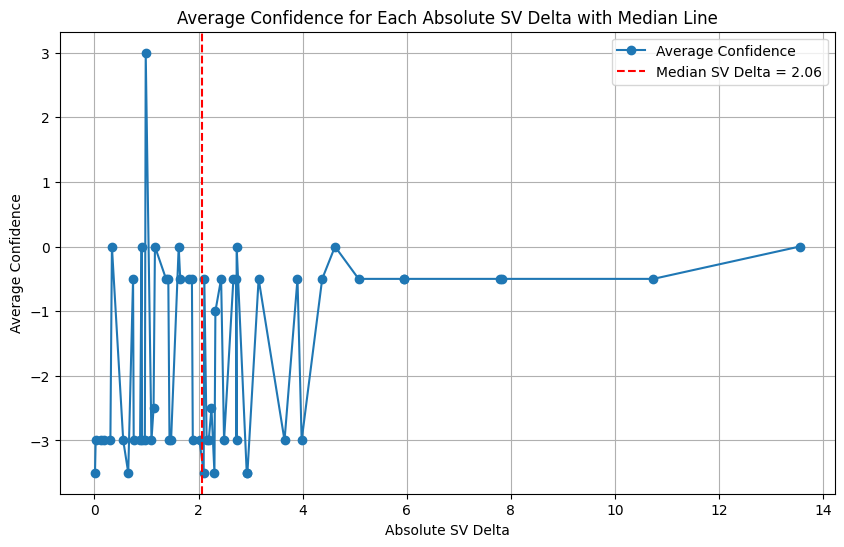

In [15]:
# Group by SV_delta_abs and calculate the mean confidence for each group
grouped_data = data.groupby('SV_delta_abs')['confidence'].mean().reset_index()

# Calculate the median of SV_delta_abs
median_sv_delta_abs = data['SV_delta_abs'].median()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['SV_delta_abs'], grouped_data['confidence'], marker='o', label='Average Confidence')
plt.axvline(median_sv_delta_abs, color='r', linestyle='--', label=f'Median SV Delta = {median_sv_delta_abs:.2f}')
plt.xlabel('Absolute SV Delta')
plt.ylabel('Average Confidence')
plt.title('Average Confidence for Each Absolute SV Delta with Median Line')
plt.legend()
plt.grid(True)
plt.show()

## Plotting Average Confidence vs. Absolute SV Delta Per Participant

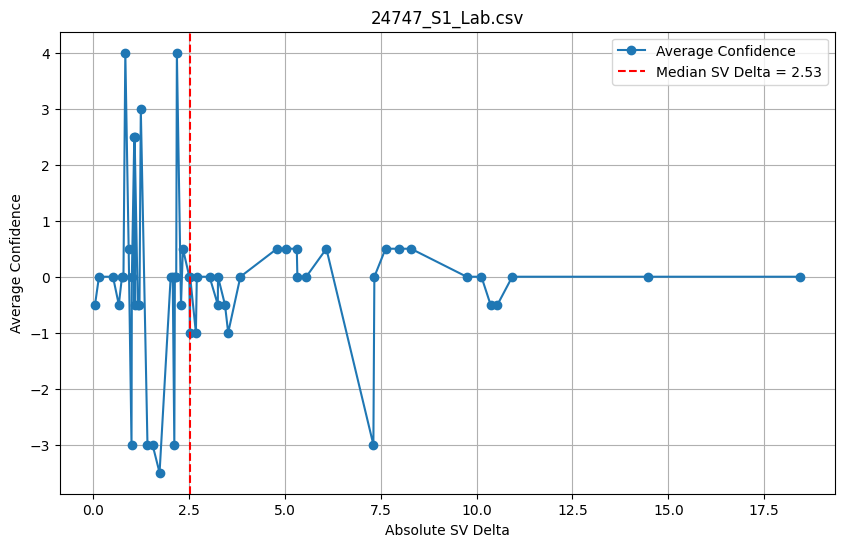

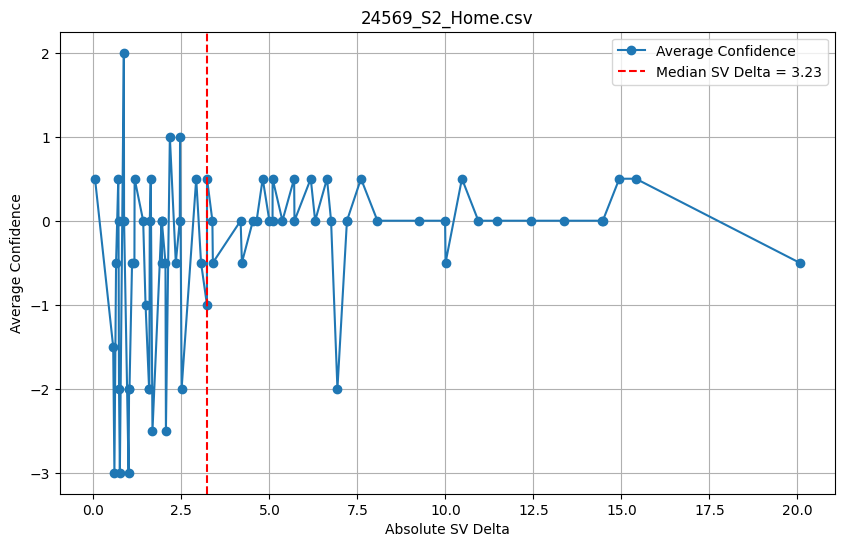

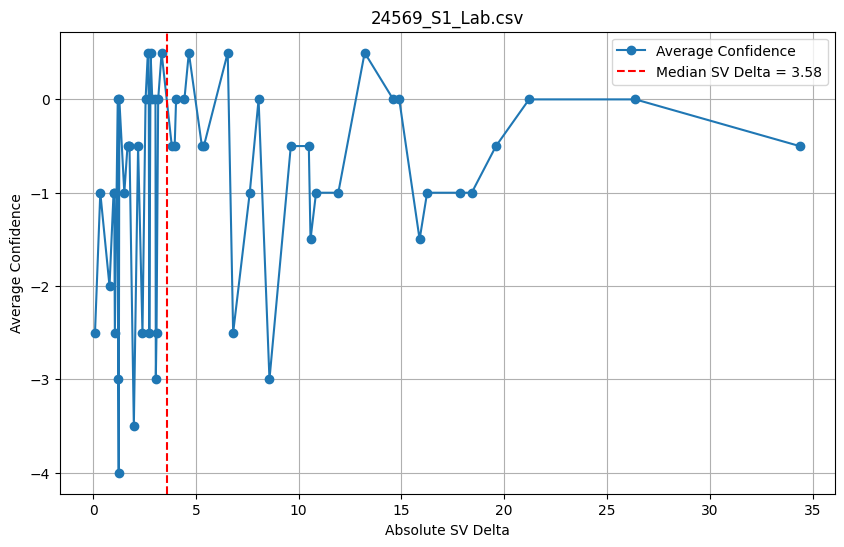

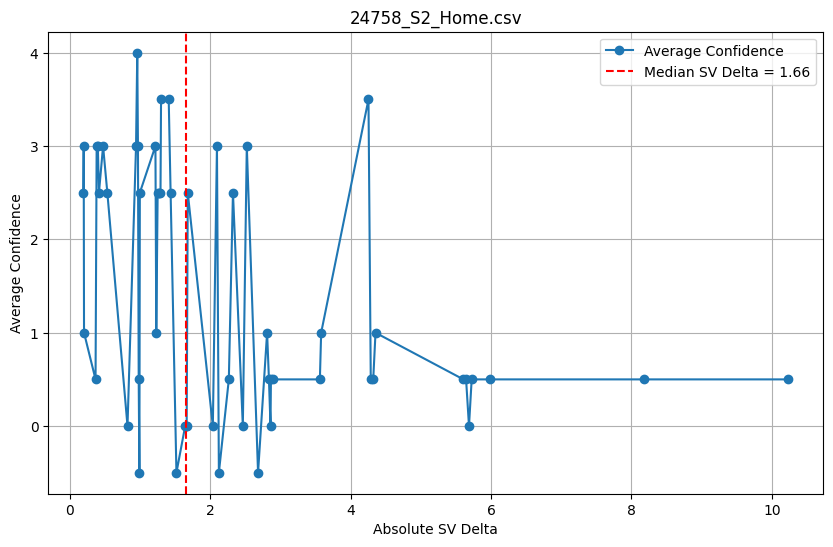

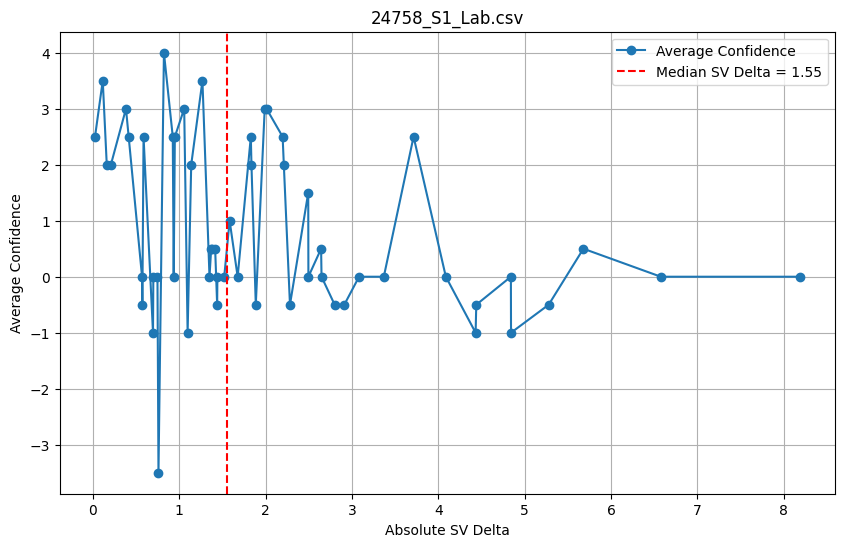

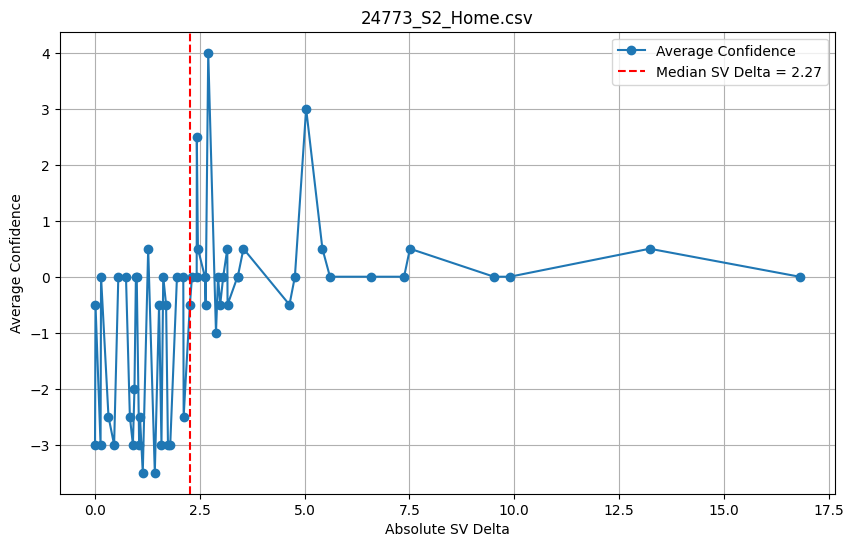

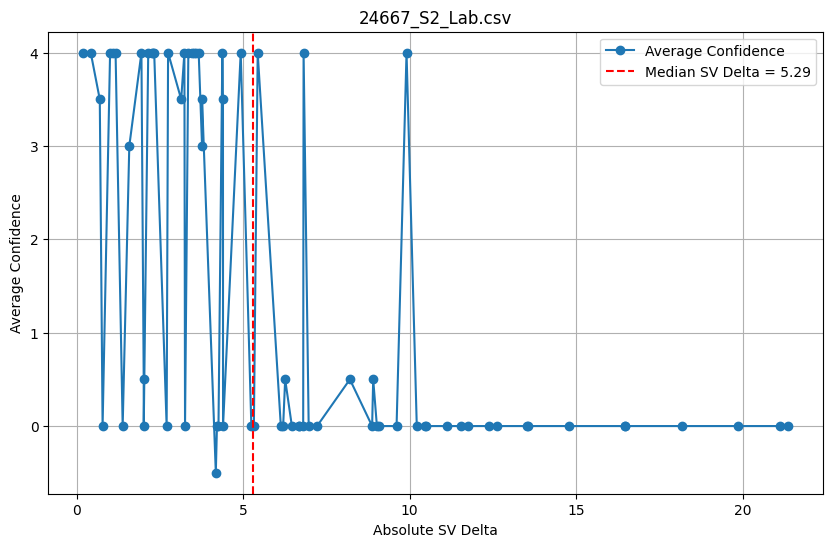

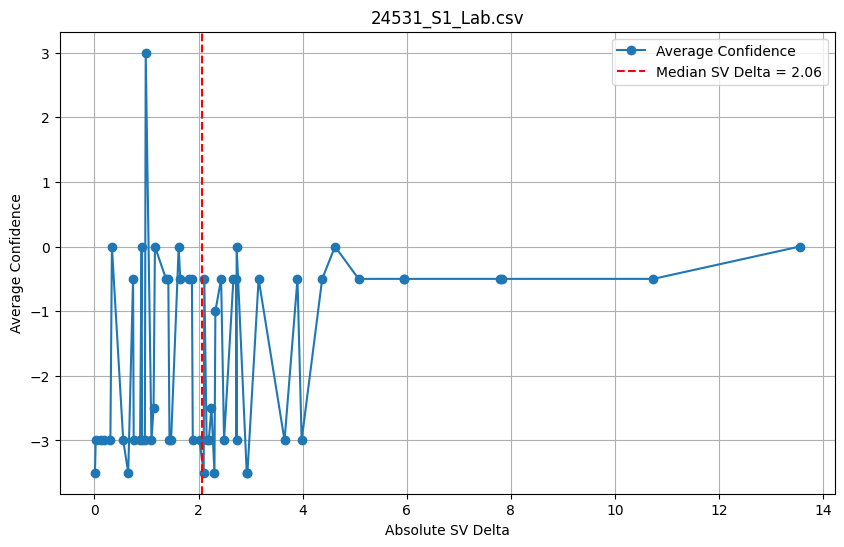

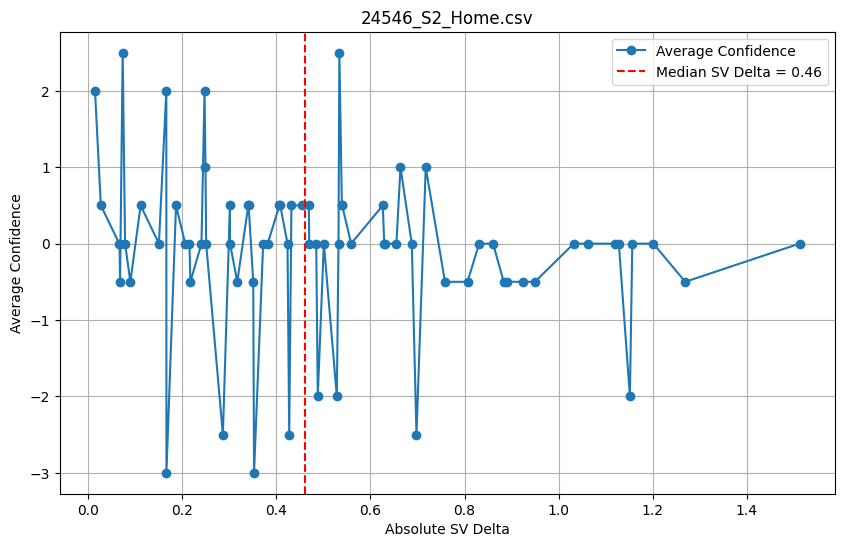

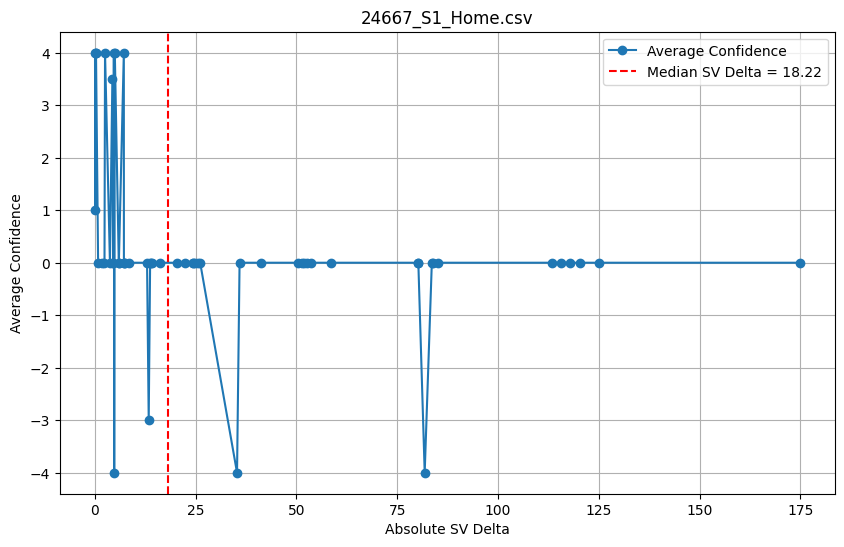

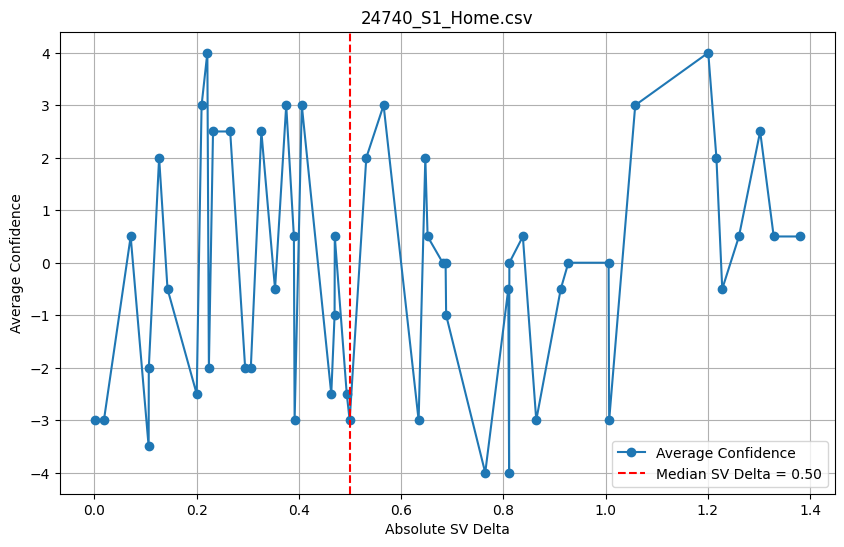

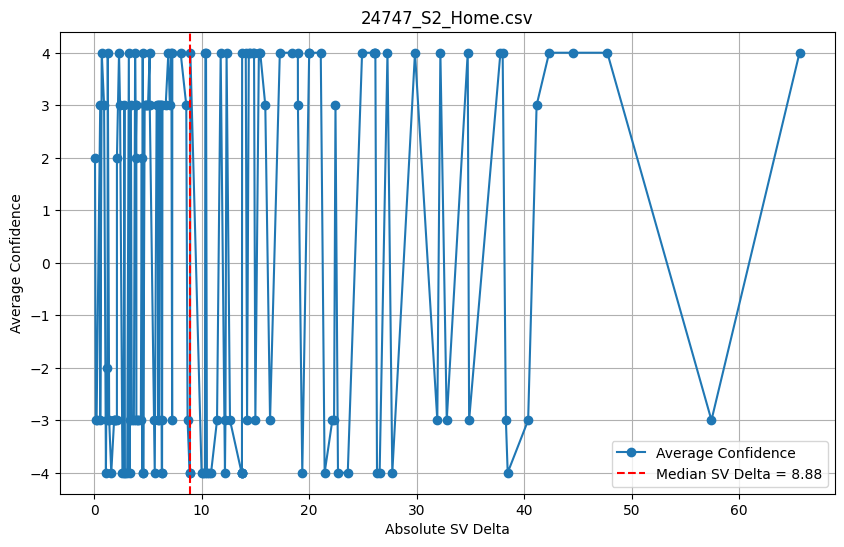

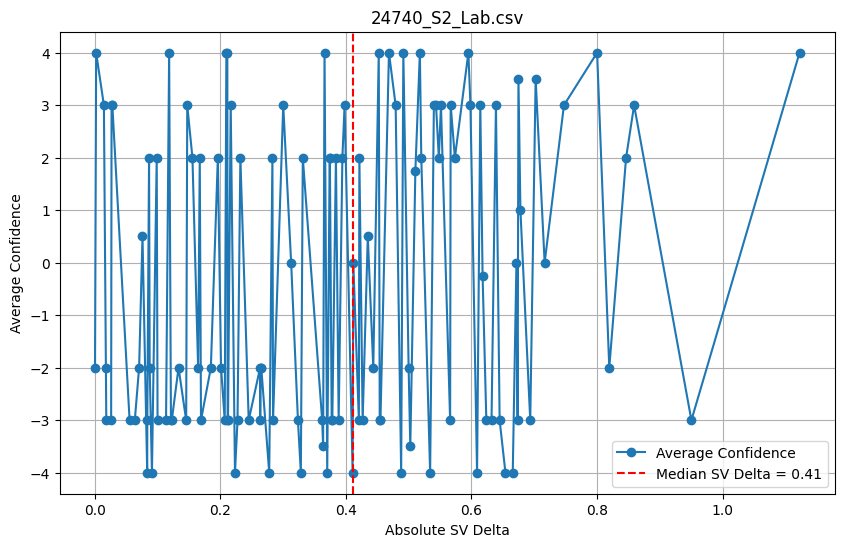

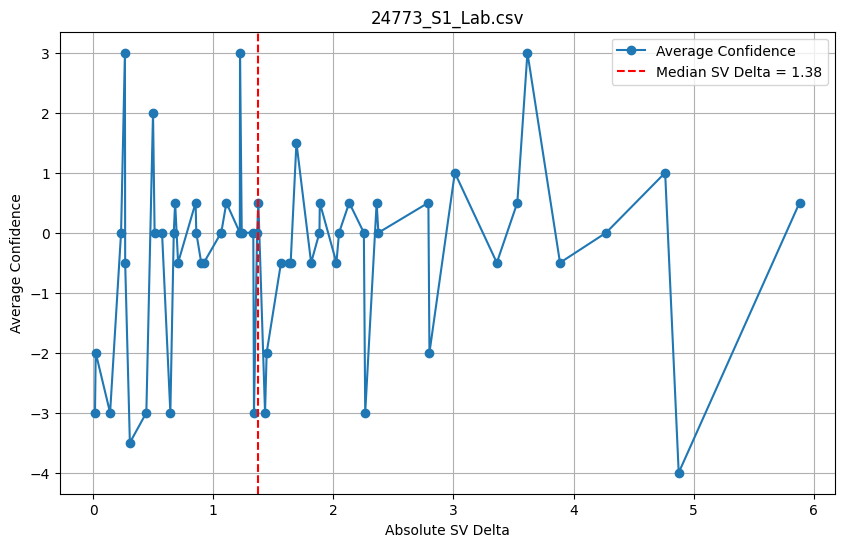

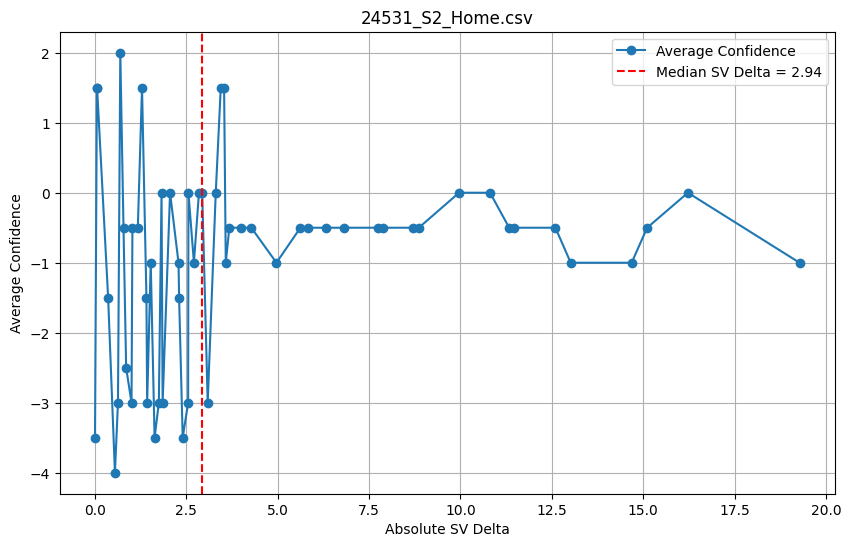

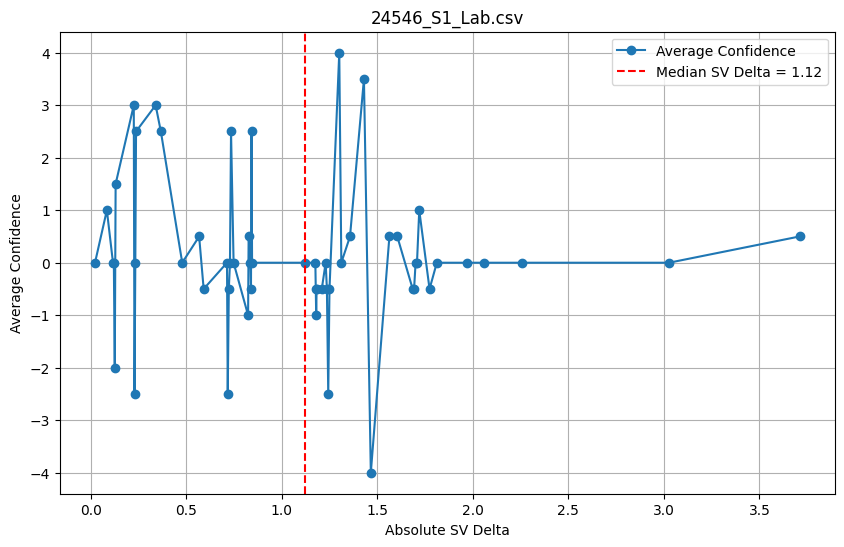

In [16]:
def plot_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Calculate the absolute values of SV_delta and find the median
    df['SV_delta_abs'] = df['SV_delta'].abs()
    median_sv_delta_abs = df['SV_delta_abs'].median()

    # Group by SV_delta_abs and calculate the mean confidence for each group
    grouped_data = df.groupby('SV_delta_abs')['confidence'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_data['SV_delta_abs'], grouped_data['confidence'], marker='o', label='Average Confidence')
    plt.axvline(median_sv_delta_abs, color='r', linestyle='--', label=f'Median SV Delta = {median_sv_delta_abs:.2f}')
    plt.xlabel('Absolute SV Delta')
    plt.ylabel('Average Confidence')
    plt.title(os.path.basename(file_path))  # Use file name as title
    plt.legend()
    plt.grid(True)
    plt.show()

# Specify your folder path here
folder_path = '/content/Confidence'

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        plot_csv(file_path)


## Confidence Comparison Between Sessions and Environment

<ipython-input-17-47dbfcc0782a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easy_df = easy_df.append(participant_df[participant_df['SV_delta_abs'] >= median])
<ipython-input-17-47dbfcc0782a>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hard_df = hard_df.append(participant_df[participant_df['SV_delta_abs'] < median])
<ipython-input-17-47dbfcc0782a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easy_df = easy_df.append(participant_df[participant_df['SV_delta_abs'] >= median])
<ipython-input-17-47dbfcc0782a>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hard_df = hard_df.append(participant_df[participant_df['SV_delta_abs

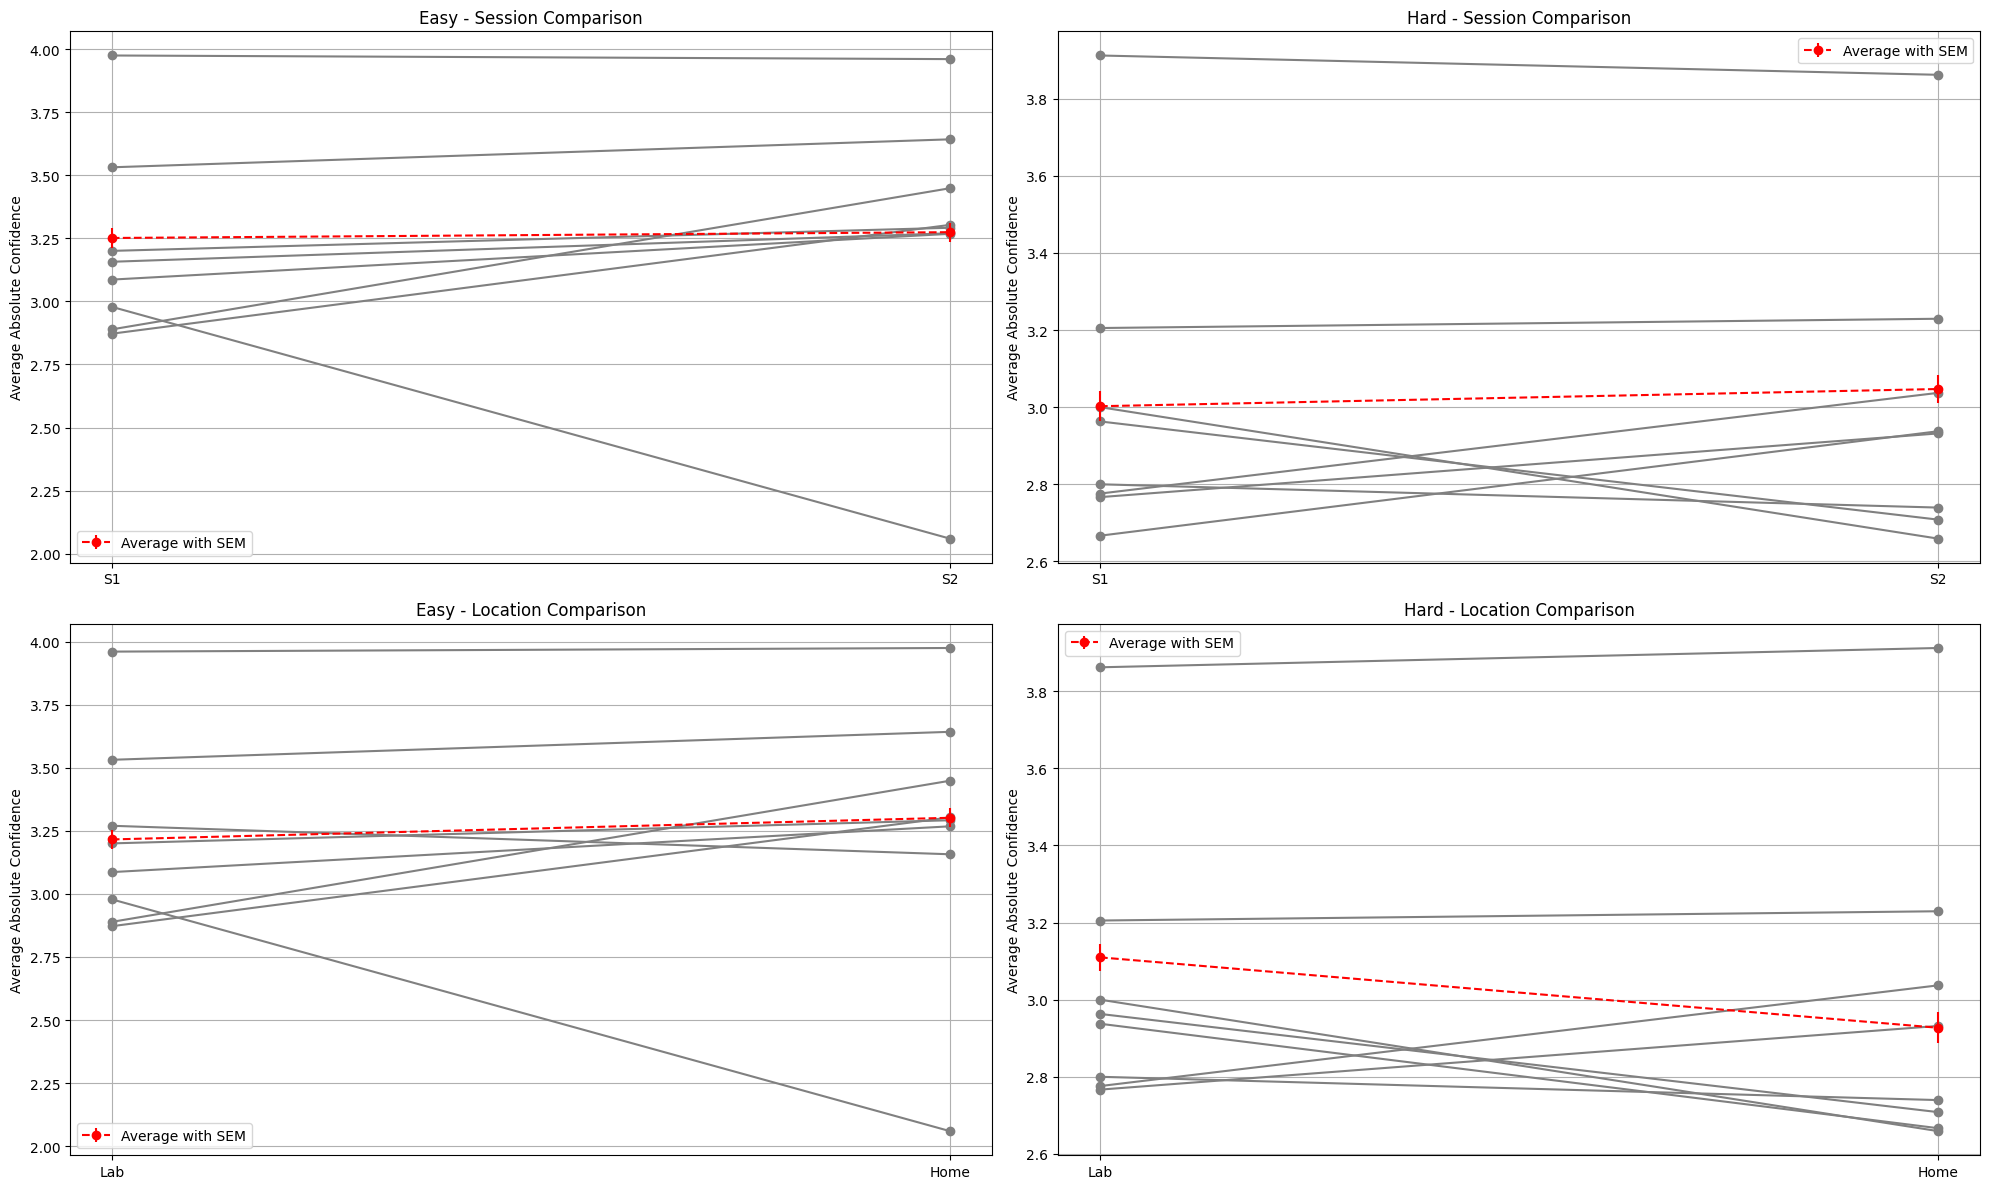

In [17]:
def plot_confidence_comparison(ax, df, title, condition):
    condition_values = sorted(df[condition].unique()) if condition == 'session' else df[condition].unique()

    # Plot individual participants
    for participant in df['participant'].unique():
        participant_df = df[df['participant'] == participant]
        participant_confidences = []
        for value in condition_values:
            value_df = participant_df[participant_df[condition] == value]
            avg_confidence = value_df['confidence'].abs().mean()  # Use absolute values for average
            participant_confidences.append(avg_confidence)
        ax.plot(condition_values, participant_confidences, color='gray', linestyle='-', marker='o')

    # Plot overall average with SEM
    overall_confidences = []
    sem_values = []
    for value in condition_values:
        value_df = df[df[condition] == value]
        overall_avg = value_df['confidence'].abs().mean()  # Use absolute values for average
        sem = stats.sem(value_df['confidence'].abs(), nan_policy='omit')  # SEM of absolute values
        overall_confidences.append(overall_avg)
        sem_values.append(sem)
    ax.errorbar(condition_values, overall_confidences, yerr=sem_values, color='red', linestyle='--', marker='o', label='Average with SEM')

    ax.set_xticks(condition_values)
    ax.set_ylabel('Average Absolute Confidence')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Load data
folder_path = '/content/Confidence'
all_data = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        participant, session, location = filename.split('_')
        location = location.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, filename))
        df['participant'] = participant
        df['session'] = session
        df['location'] = location
        df['SV_delta_abs'] = df['SV_delta'].abs()
        all_data.append(df)

combined_df = pd.concat(all_data)

# Calculate each participant's median absolute SV Delta
participant_medians = combined_df.groupby('participant')['SV_delta_abs'].median()
easy_df, hard_df = pd.DataFrame(), pd.DataFrame()

for participant, median in participant_medians.items():
    participant_df = combined_df[combined_df['participant'] == participant]
    easy_df = easy_df.append(participant_df[participant_df['SV_delta_abs'] >= median])
    hard_df = hard_df.append(participant_df[participant_df['SV_delta_abs'] < median])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Create each plot
plot_confidence_comparison(axs[0, 0], easy_df, 'Easy - Session Comparison', 'session')
plot_confidence_comparison(axs[0, 1], hard_df, 'Hard - Session Comparison', 'session')
plot_confidence_comparison(axs[1, 0], easy_df, 'Easy - Location Comparison', 'location')
plot_confidence_comparison(axs[1, 1], hard_df, 'Hard - Location Comparison', 'location')

plt.tight_layout()
plt.show()


# Parameters

## Parameter Plots

<ipython-input-18-0a9bd6fa60e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['session'] = pd.Categorical(combined_data['session'], ['S1', 'S2'])
<ipython-input-18-0a9bd6fa60e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['environment'] = pd.Categorical(combined_data['environment'], ['Lab', 'Home'])


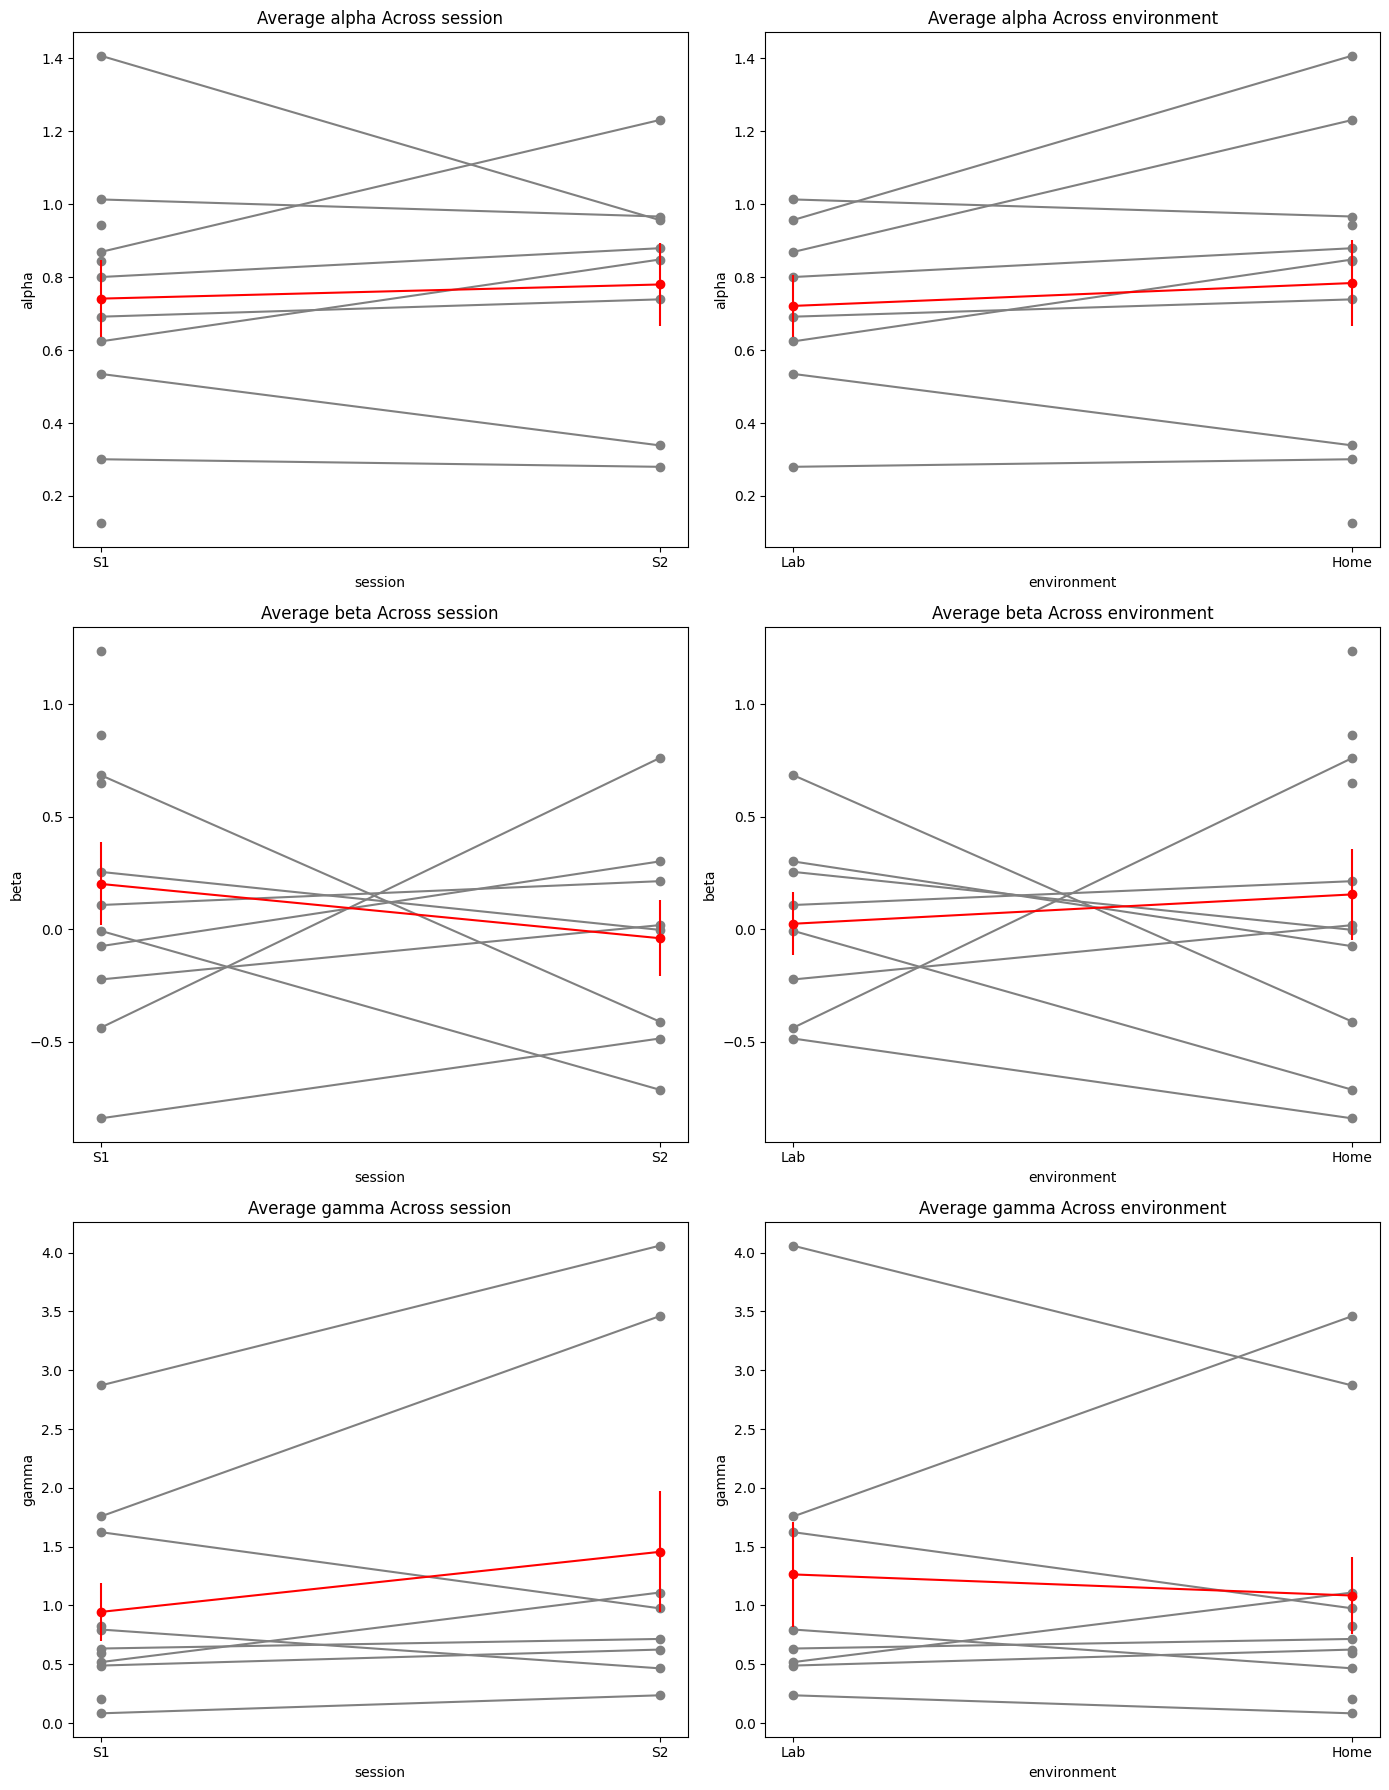

In [18]:
def plot_two_way_lines(new_crdm, variable1, variable2, variable3):
    # Filter for a specific domain (e.g., 'combined')
    combined_data = new_crdm[new_crdm['domain'] == 'combined']

    # Ensuring session and environment order
    combined_data['session'] = pd.Categorical(combined_data['session'], ['S1', 'S2'])
    combined_data['environment'] = pd.Categorical(combined_data['environment'], ['Lab', 'Home'])

    # Set up the matplotlib figure
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 rows, 2 columns

    # Function to plot individual and average lines with SEM
    def plot_lines(data, x_col, y_col, ax):
        # Sort data by x_col for consistent plotting order
        sorted_data = data.sort_values(by=x_col)

        # Plot individual participant lines in a consistent gray color
        for subid in sorted_data['subid'].unique():
            subid_data = sorted_data[sorted_data['subid'] == subid]
            ax.plot(subid_data[x_col], subid_data[y_col], color='gray', marker='o', linestyle='-')

        # Calculate and plot average and SEM
        avg_data = sorted_data.groupby(x_col)[y_col].agg(['mean', 'sem']).reset_index()
        ax.errorbar(avg_data[x_col], avg_data['mean'], yerr=avg_data['sem'], color='red', label='Average with SEM', fmt='o-')

        # Setting title and labels
        ax.set_title(f'Average {y_col} Across {x_col}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

    # Plot for variable1 by session and environment
    plot_lines(combined_data, 'session', variable1, axes[0, 0])
    plot_lines(combined_data, 'environment', variable1, axes[0, 1])

    # Plot for variable2 by session and environment
    plot_lines(combined_data, 'session', variable2, axes[1, 0])
    plot_lines(combined_data, 'environment', variable2, axes[1, 1])

    # Plot for variable3 by session and environment
    plot_lines(combined_data, 'session', variable3, axes[2, 0])
    plot_lines(combined_data, 'environment', variable3, axes[2, 1])

    plt.tight_layout()
    plt.show()


new_crdm = new_crdm
plot_two_way_lines(new_crdm, 'alpha', 'beta', 'gamma')

## Statistical Tests

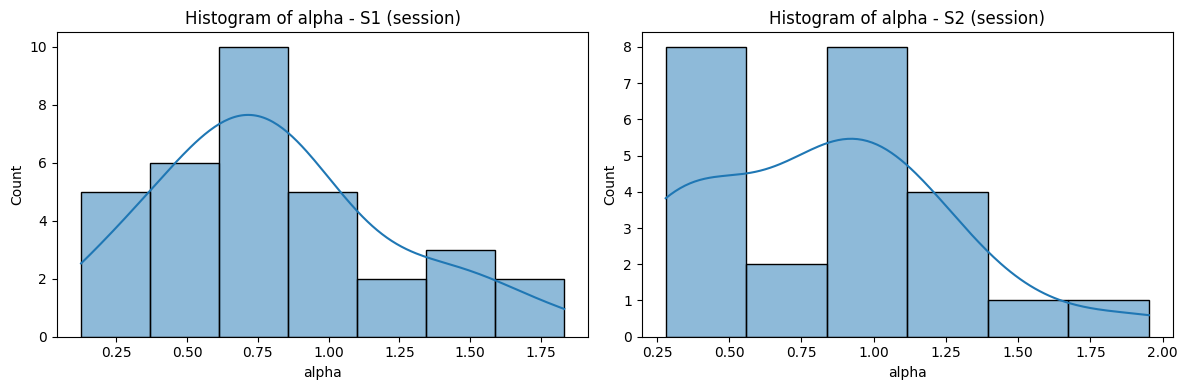

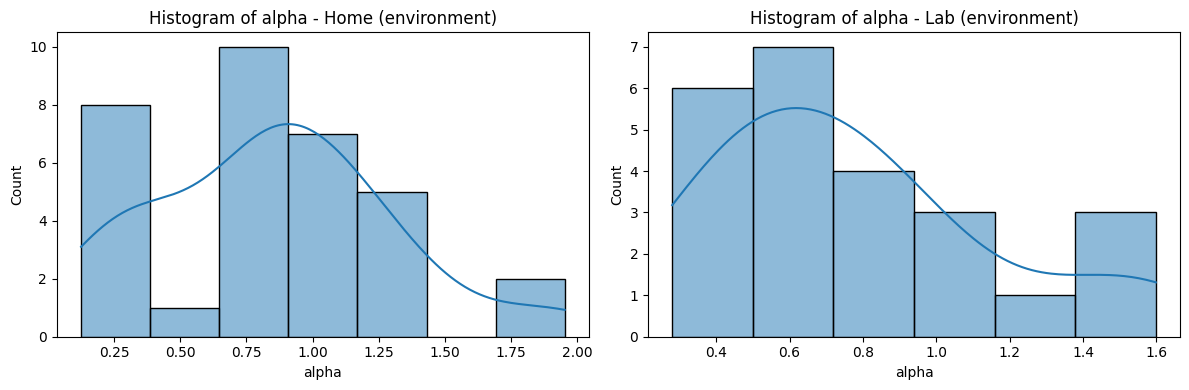

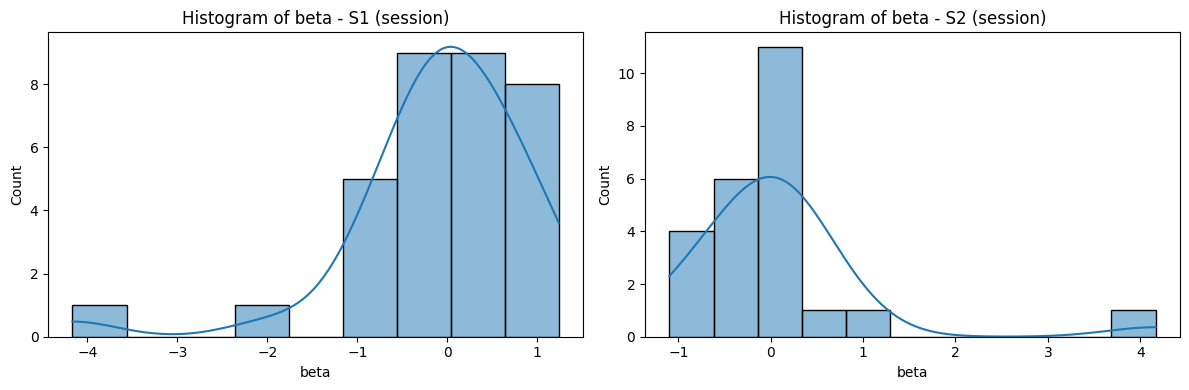

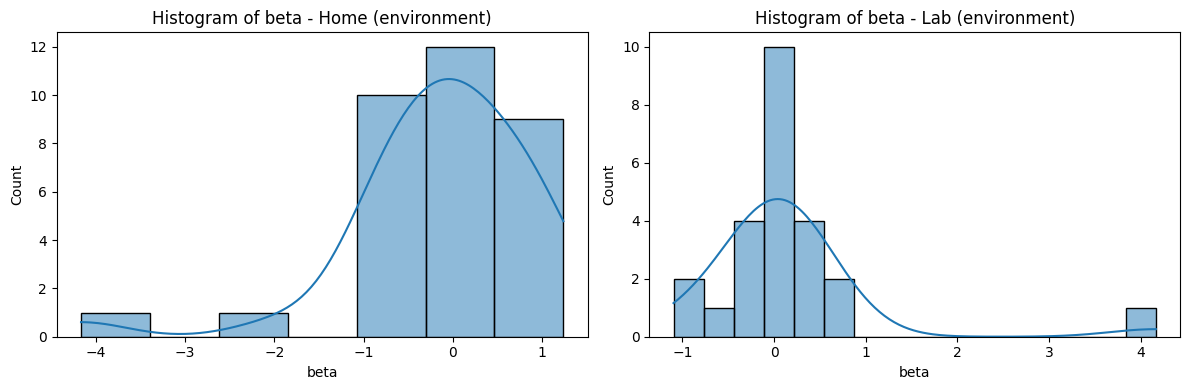

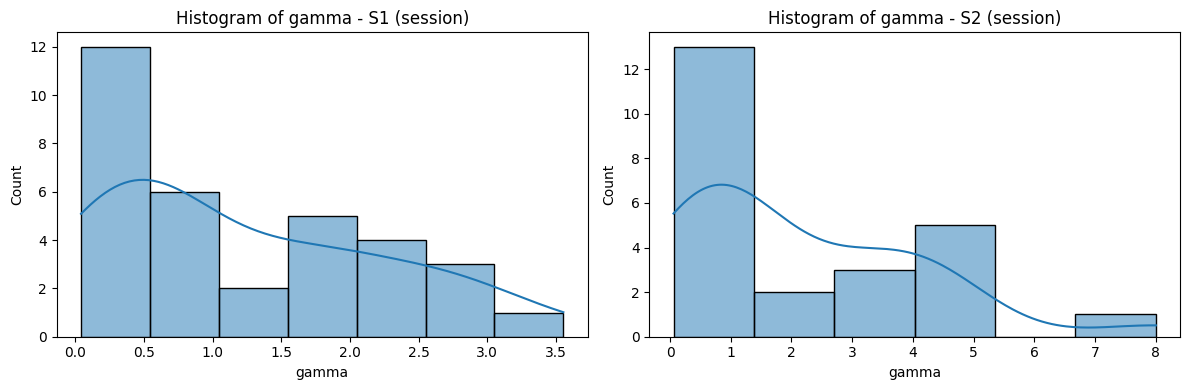

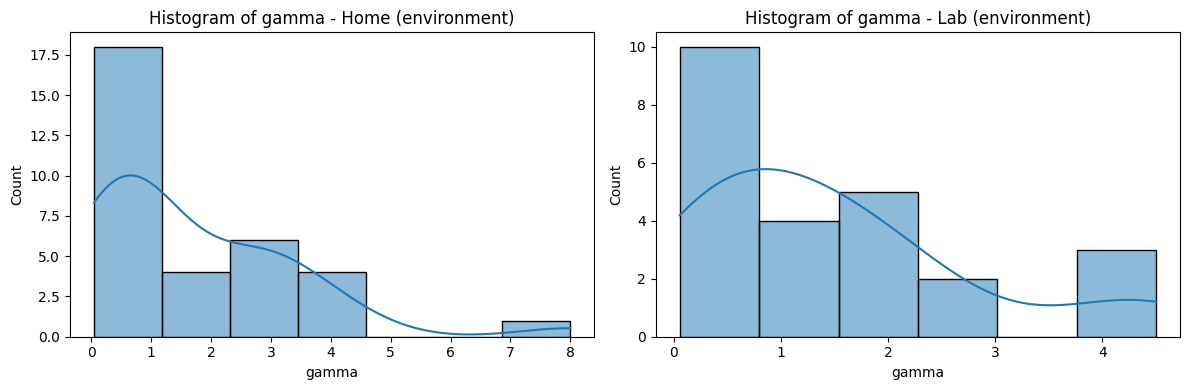

  Feature     Category            Test  Test Statistic   p-Value
0   alpha      session          T-test       -0.217315  0.828767
1   alpha  environment  Mann-Whitney U      448.000000  0.405187
2    beta      session  Mann-Whitney U      408.000000  0.852546
3    beta  environment  Mann-Whitney U      376.000000  0.752631
4   gamma      session  Mann-Whitney U      291.000000  0.091219
5   gamma  environment  Mann-Whitney U      401.000000  0.942019


In [19]:
def assess_distributions_and_compare(dataframe):
    results = []
    numerical_features = ['alpha', 'beta', 'gamma']


    # Iterate over each specified numerical feature
    for column in numerical_features:
        if column in dataframe.columns:
            # Iterate over the two categories: session and environment
            for category in ['session', 'environment']:
                # Split the data by category
                category_groups = dataframe.groupby(category)[column]

                # Check if data can be compared (i.e., two groups present)
                if len(category_groups) == 2:
                    data_groups = [group.dropna() for name, group in category_groups]

                    # Perform Shapiro-Wilk test for normality
                    shapiro_tests = [stats.shapiro(data) for data in data_groups]

                    # Determine the test based on normality
                    if all(p > 0.05 for stat, p in shapiro_tests):
                        test_stat, p_val = stats.ttest_ind(*data_groups)
                        test_name = 'T-test'
                    else:
                        test_stat, p_val = stats.mannwhitneyu(*data_groups)
                        test_name = 'Mann-Whitney U'

                    # Compile results
                    result = {
                        'Feature': column,
                        'Category': category,
                        'Test': test_name,
                        'Test Statistic': test_stat,
                        'p-Value': p_val
                    }
                    results.append(result)

                    # Create histogram for each group
                    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                    for i, (name, group) in enumerate(category_groups):
                        sns.histplot(group, kde=True, ax=ax[i])
                        ax[i].set_title(f'Histogram of {column} - {name} ({category})')
                    plt.tight_layout()
                    plt.show()

                else:
                    print(f"Skipping {column}, as there are not exactly two groups in {category}.")
        else:
            print(f"Skipping non-existent column: {column}")

    return pd.DataFrame(results)

# Example usage
df = new_crdm
distribution_results = assess_distributions_and_compare(df)
print(distribution_results)


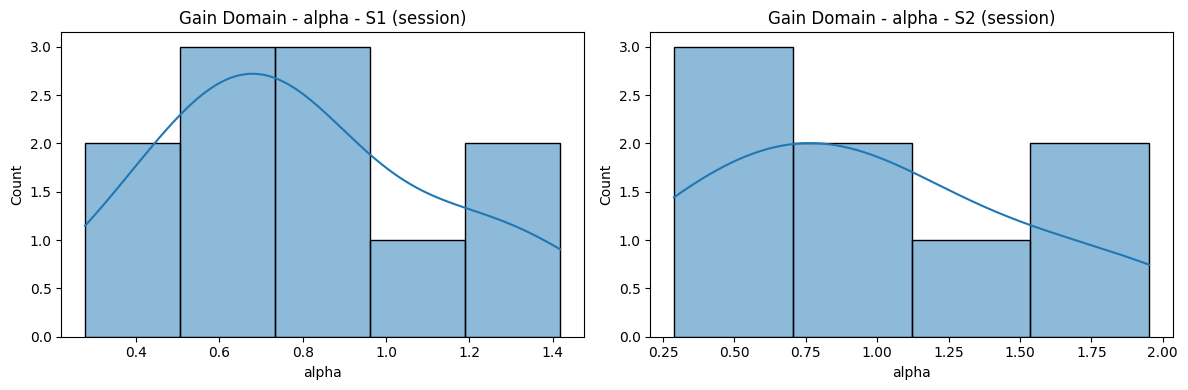

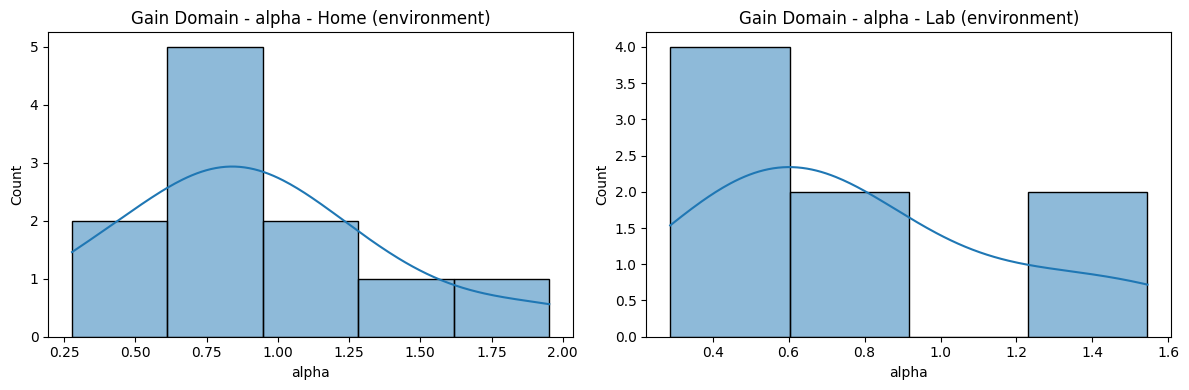

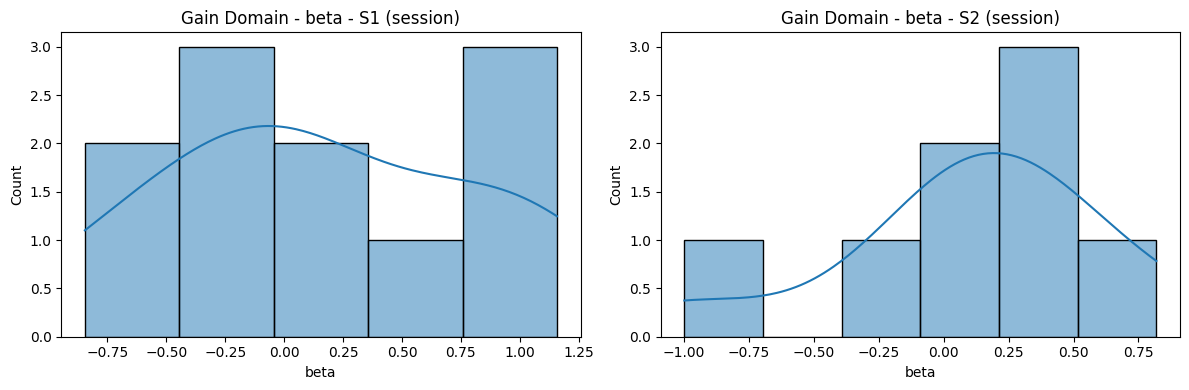

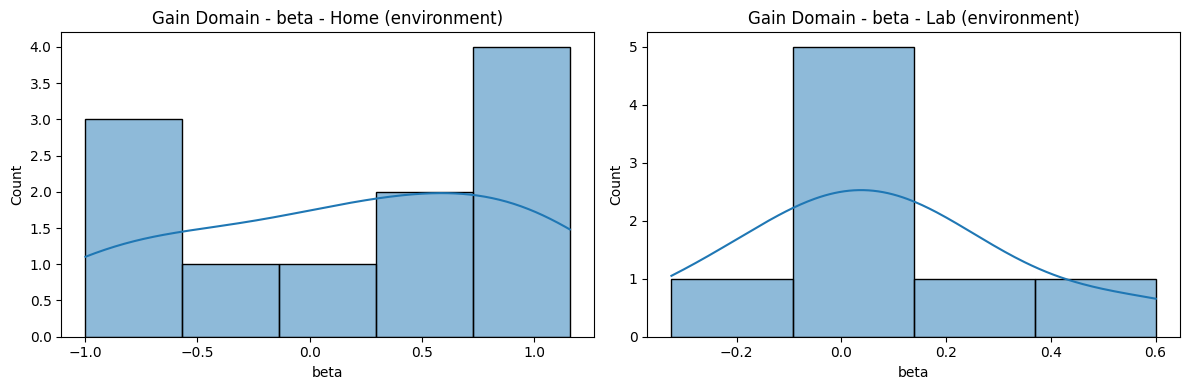

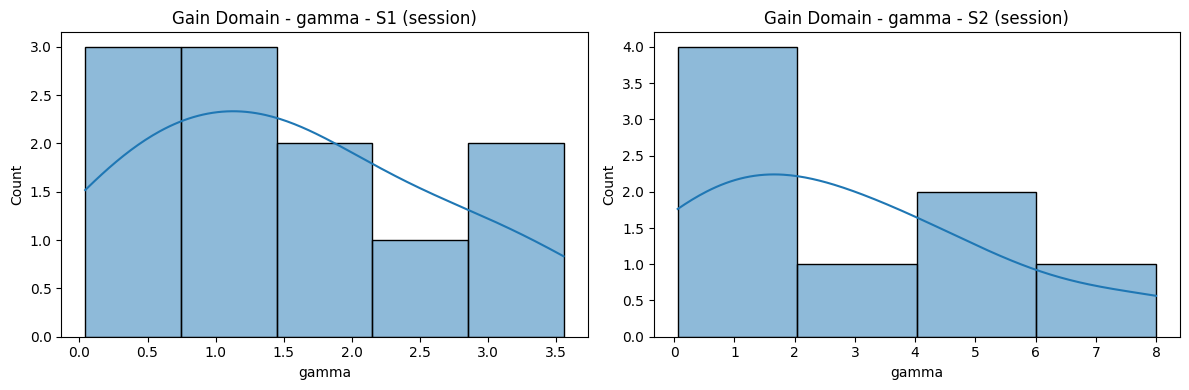

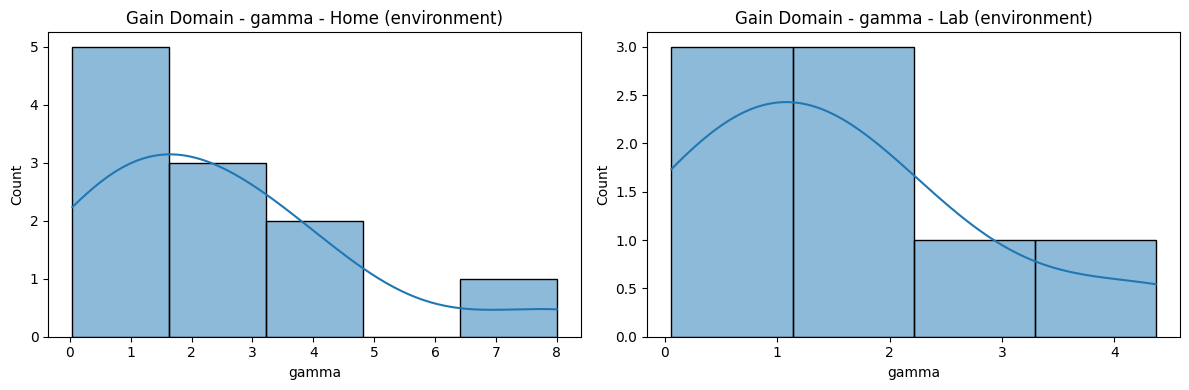

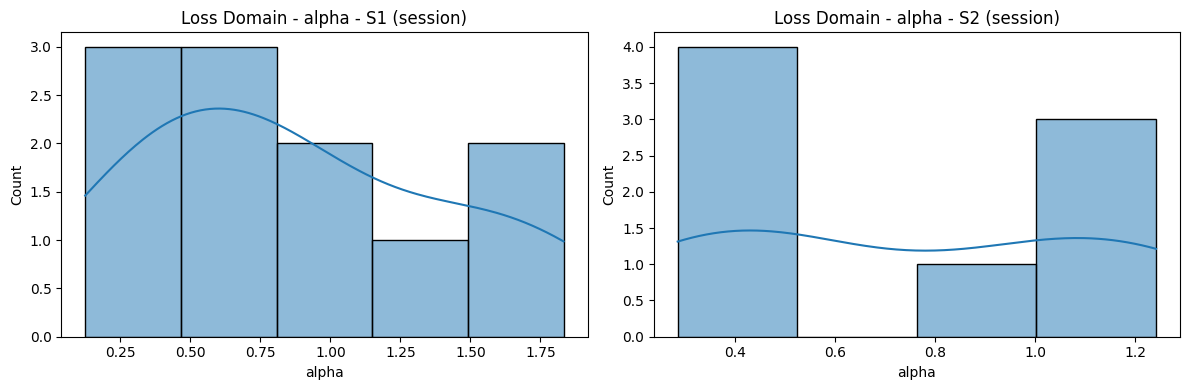

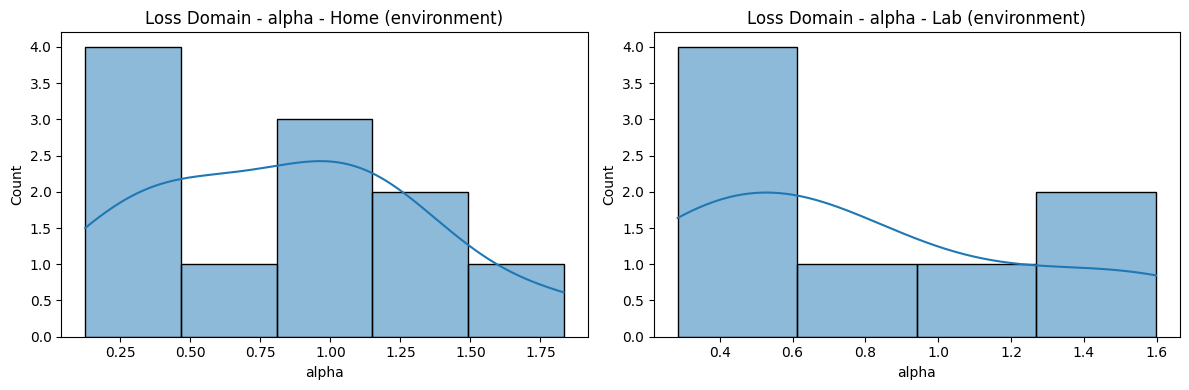

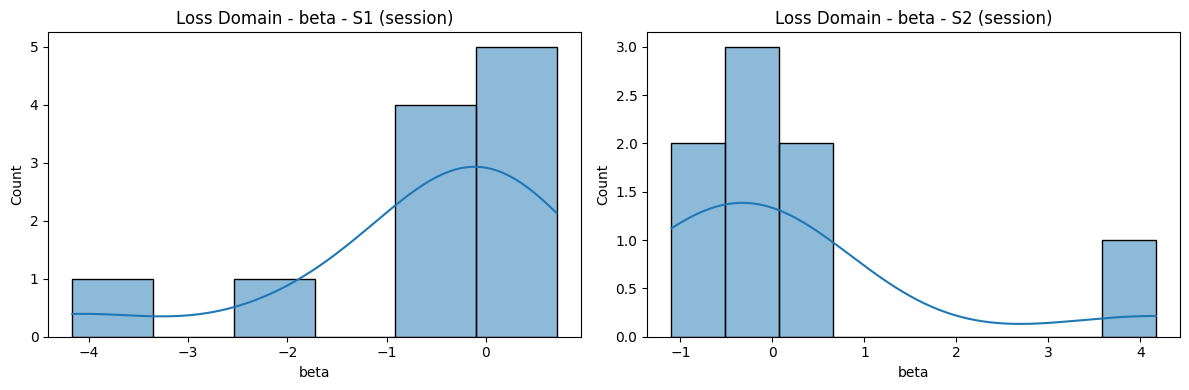

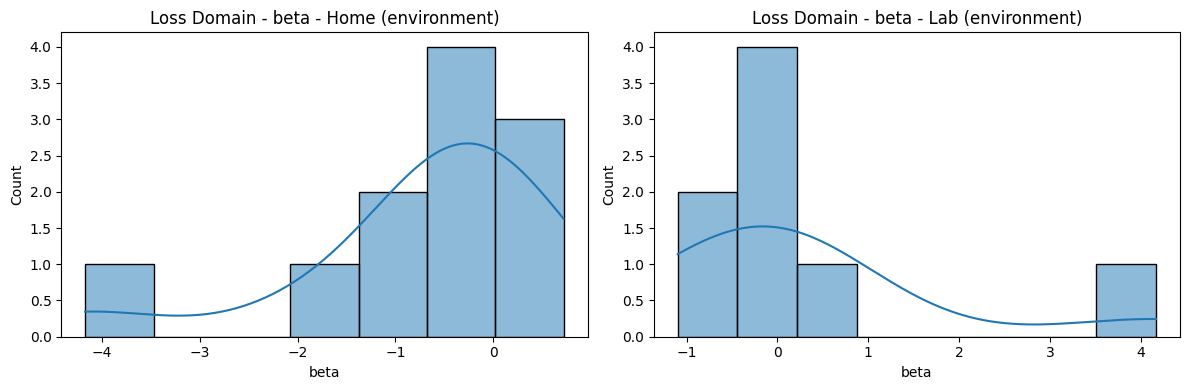

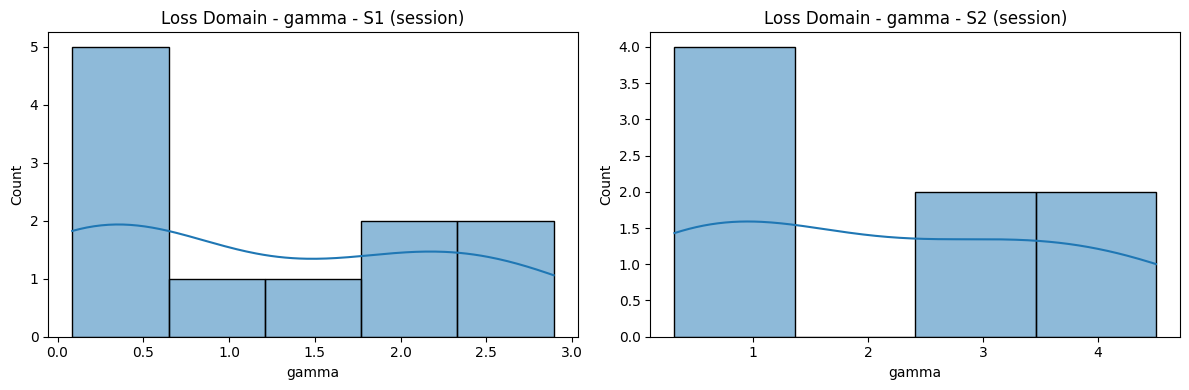

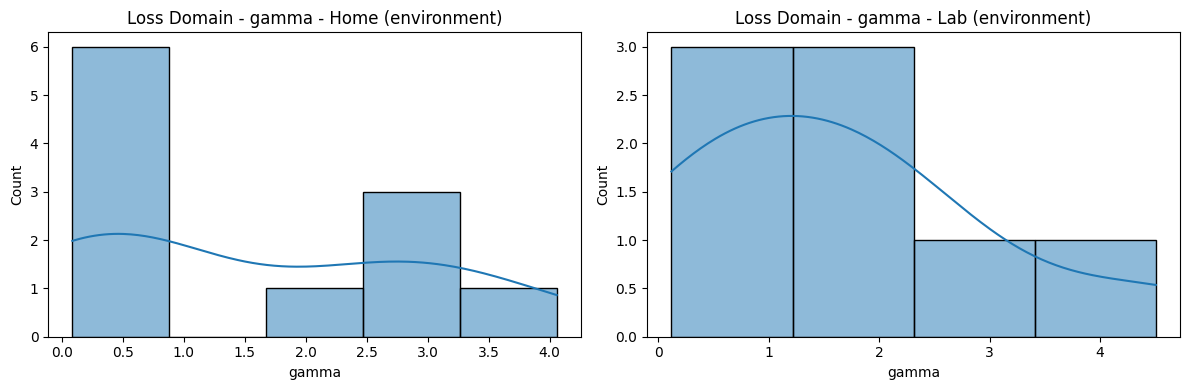

   Domain Feature     Category            Test  Test Statistic   p-Value
0    gain   alpha      session          T-test       -0.756443  0.459739
1    gain   alpha  environment          T-test        0.670095  0.511798
2    gain    beta      session          T-test        0.275066  0.786581
3    gain    beta  environment          T-test        0.320222  0.752702
4    gain   gamma      session          T-test       -1.516071  0.147875
5    gain   gamma  environment          T-test        1.020998  0.321566
6    loss   alpha      session          T-test        0.533338  0.600704
7    loss   alpha  environment          T-test        0.149474  0.882939
8    loss    beta      session  Mann-Whitney U       39.000000  0.716784
9    loss    beta  environment  Mann-Whitney U       30.000000  0.272287
10   loss   gamma      session          T-test       -1.500840  0.151741
11   loss   gamma  environment  Mann-Whitney U       43.000000  0.967849


In [20]:
def assess_distributions_and_compare(dataframe):
    results = []
    numerical_features = ['alpha', 'beta', 'gamma']
    domains = ['gain', 'loss']

    # Iterate over each domain and numerical feature
    for domain in domains:
        domain_data = dataframe[dataframe['domain'] == domain]

        for column in numerical_features:
            if column in domain_data.columns:
                # Iterate over the two categories: session and environment
                for category in ['session', 'environment']:
                    # Split the data by category within the domain
                    category_groups = domain_data.groupby(category)[column]

                    if len(category_groups) == 2:
                        data_groups = [group.dropna() for name, group in category_groups]
                        shapiro_tests = [stats.shapiro(data) for data in data_groups]

                        if all(p > 0.05 for stat, p in shapiro_tests):
                            test_stat, p_val = stats.ttest_ind(*data_groups)
                            test_name = 'T-test'
                        else:
                            test_stat, p_val = stats.mannwhitneyu(*data_groups)
                            test_name = 'Mann-Whitney U'

                        result = {
                            'Domain': domain,
                            'Feature': column,
                            'Category': category,
                            'Test': test_name,
                            'Test Statistic': test_stat,
                            'p-Value': p_val
                        }
                        results.append(result)

                        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                        for i, (name, group) in enumerate(category_groups):
                            sns.histplot(group, kde=True, ax=ax[i])
                            ax[i].set_title(f'{domain.capitalize()} Domain - {column} - {name} ({category})')
                        plt.tight_layout()
                        plt.show()
                    else:
                        print(f"Skipping {column}, as there are not exactly two groups in {category} for {domain} domain.")
            else:
                print(f"Skipping non-existent column: {column}")

    return pd.DataFrame(results)

# Example usage
df = new_crdm
distribution_results = assess_distributions_and_compare(df)
print(distribution_results)


In [21]:
def assess_distributions_and_compare(dataframe, pdf_filepath):
    results = []
    numerical_features = ['alpha', 'beta', 'gamma']
    domains = ['gain', 'loss']

    # Initialize a PDF file for the plots
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filepath)

    # Iterate over each domain and numerical feature
    for domain in domains:
        domain_data = dataframe[dataframe['domain'] == domain]

        for column in numerical_features:
            if column in domain_data.columns:
                # Iterate over the two categories: session and environment
                for category in ['session', 'environment']:
                    # Split the data by category within the domain
                    category_groups = domain_data.groupby(category)[column]

                    if len(category_groups) == 2:
                        data_groups = [group.dropna() for name, group in category_groups]
                        shapiro_tests = [stats.shapiro(data) for data in data_groups]

                        if all(p > 0.05 for stat, p in shapiro_tests):
                            test_stat, p_val = stats.ttest_ind(*data_groups)
                            test_name = 'T-test'
                        else:
                            test_stat, p_val = stats.mannwhitneyu(*data_groups)
                            test_name = 'Mann-Whitney U'

                        result = {
                            'Domain': domain,
                            'Feature': column,
                            'Category': category,
                            'Test': test_name,
                            'Test Statistic': test_stat,
                            'p-Value': p_val
                        }
                        results.append(result)

                        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                        for i, (name, group) in enumerate(category_groups):
                            sns.histplot(group, kde=True, ax=ax[i])
                            ax[i].set_title(f'{domain.capitalize()} Domain - {column} - {name} ({category})')
                        plt.tight_layout()
                        pdf.savefig(fig)  # Save the current figure into the PDF
                        plt.close(fig)
                    else:
                        print(f"Skipping {column}, as there are not exactly two groups in {category} for {domain} domain.")
            else:
                print(f"Skipping non-existent column: {column}")

    # Close the PDF file
    pdf.close()

    return pd.DataFrame(results)

# Example usage
df = new_crdm  # Ensure new_crdm is the DataFrame you're working with
pdf_filepath = 'parameter_gain_loss_session_environment_distributions.pdf'  # Replace with your desired path
distribution_results = assess_distributions_and_compare(df, pdf_filepath)
print(distribution_results)


   Domain Feature     Category            Test  Test Statistic   p-Value
0    gain   alpha      session          T-test       -0.756443  0.459739
1    gain   alpha  environment          T-test        0.670095  0.511798
2    gain    beta      session          T-test        0.275066  0.786581
3    gain    beta  environment          T-test        0.320222  0.752702
4    gain   gamma      session          T-test       -1.516071  0.147875
5    gain   gamma  environment          T-test        1.020998  0.321566
6    loss   alpha      session          T-test        0.533338  0.600704
7    loss   alpha  environment          T-test        0.149474  0.882939
8    loss    beta      session  Mann-Whitney U       39.000000  0.716784
9    loss    beta  environment  Mann-Whitney U       30.000000  0.272287
10   loss   gamma      session          T-test       -1.500840  0.151741
11   loss   gamma  environment  Mann-Whitney U       43.000000  0.967849


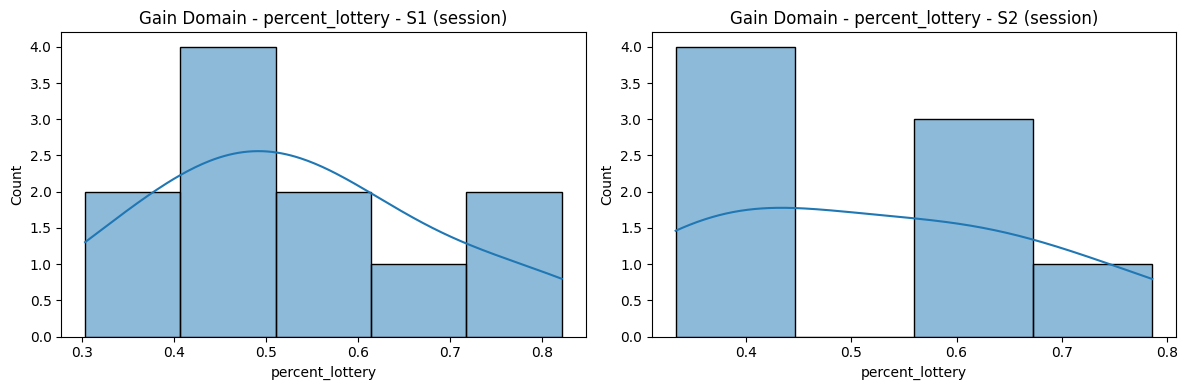

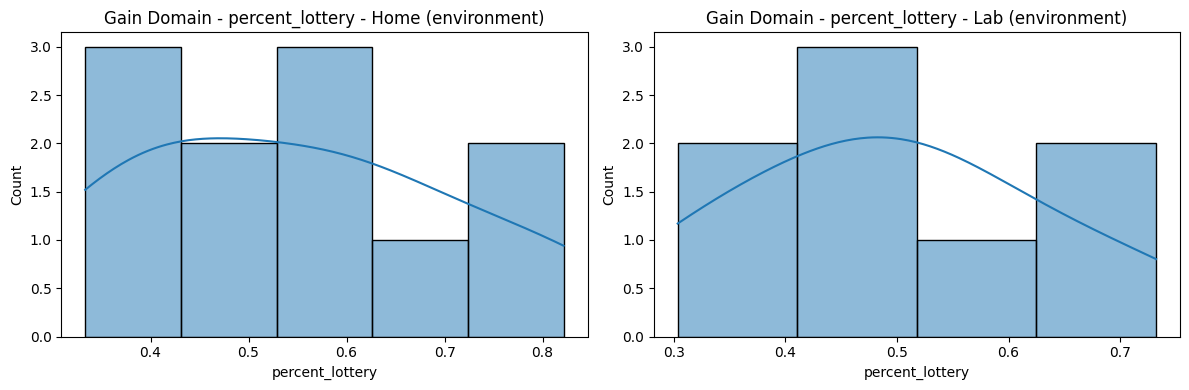

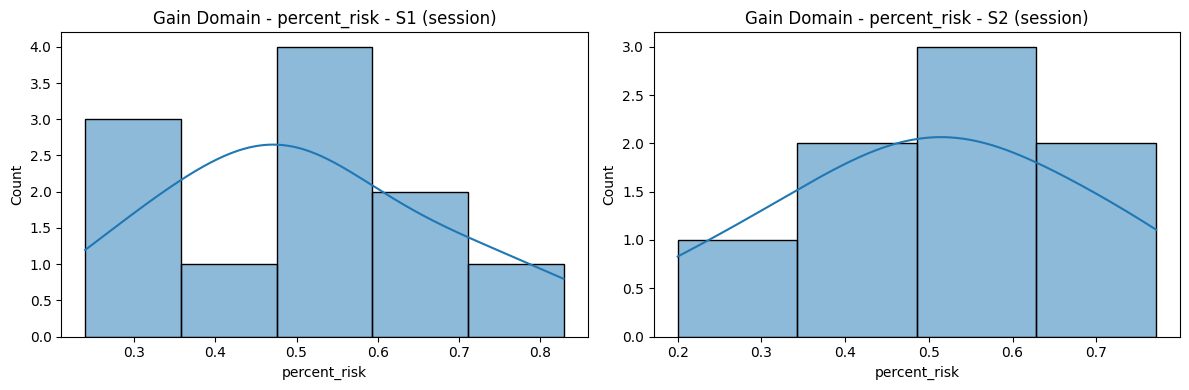

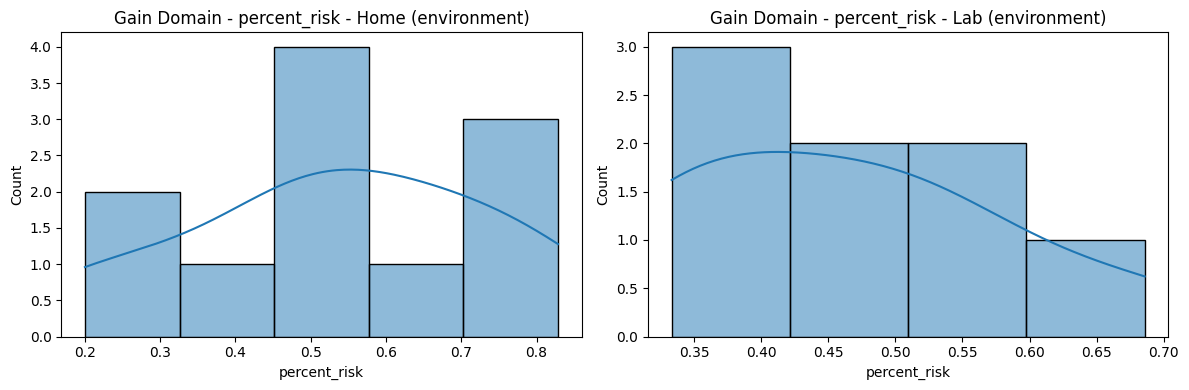

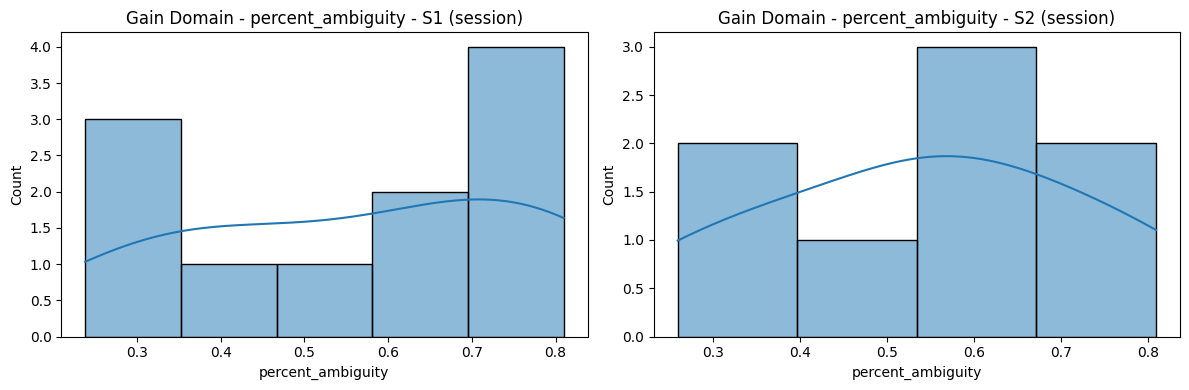

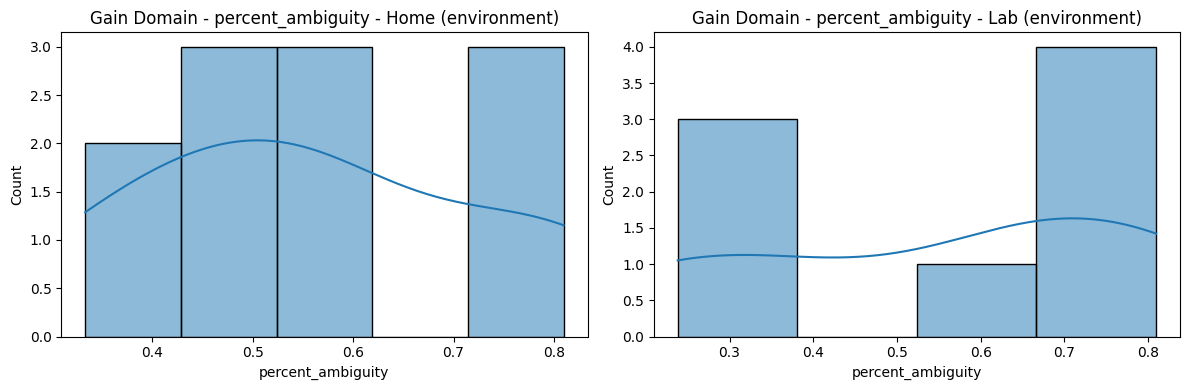

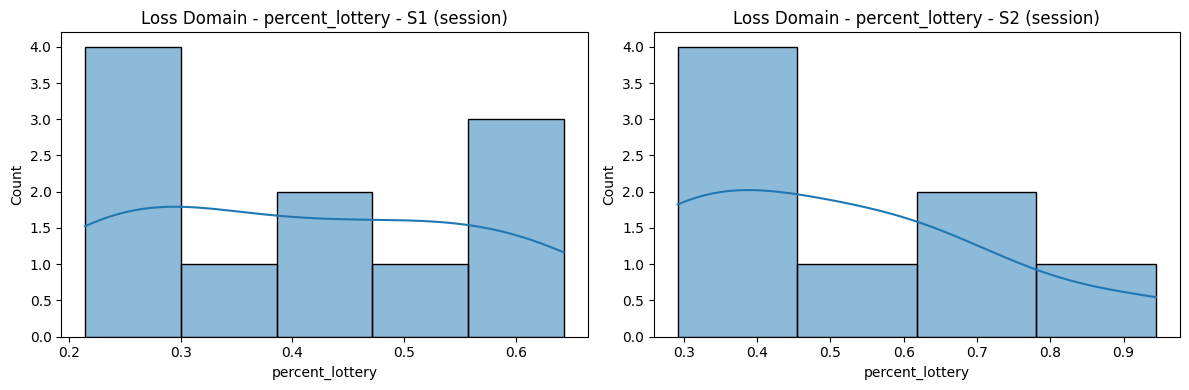

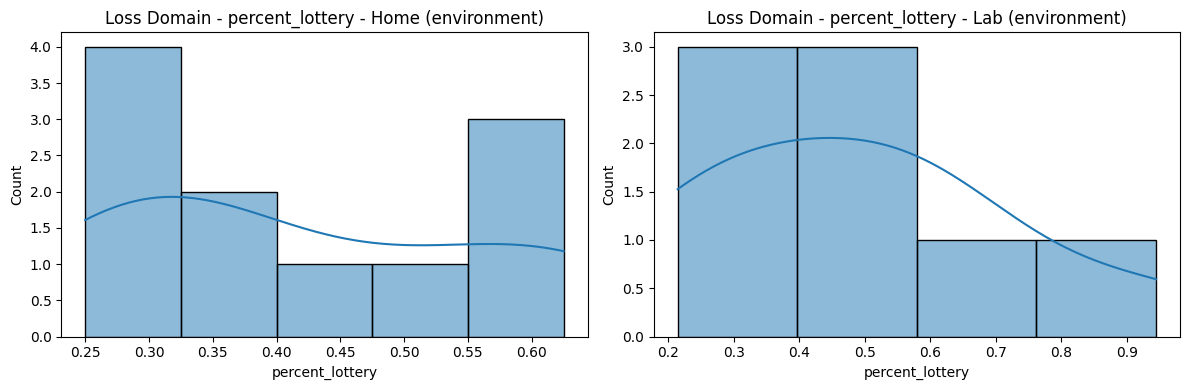

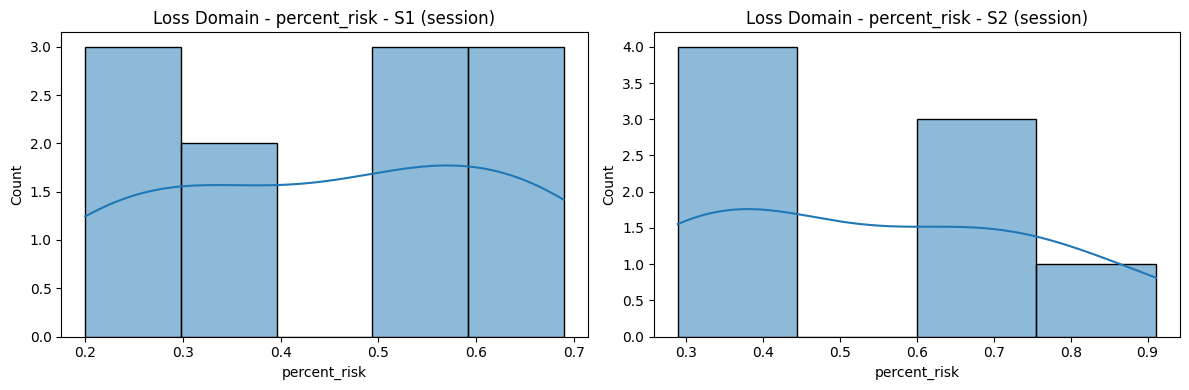

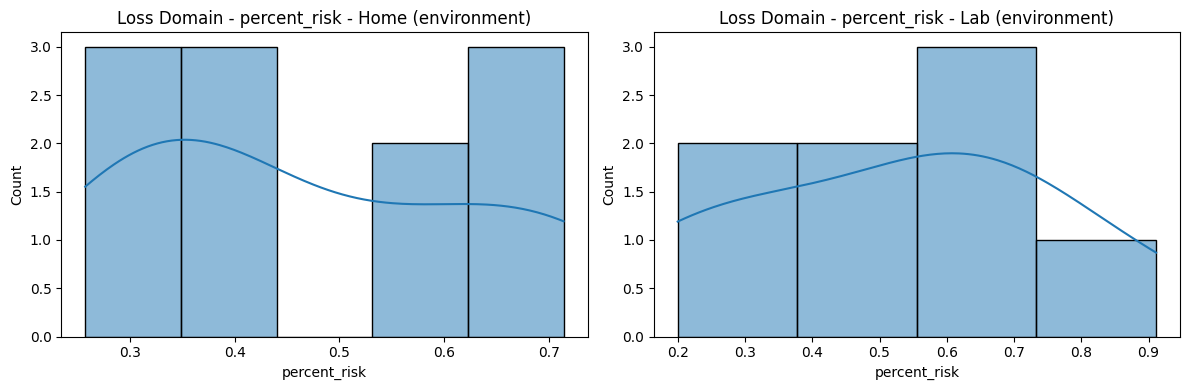

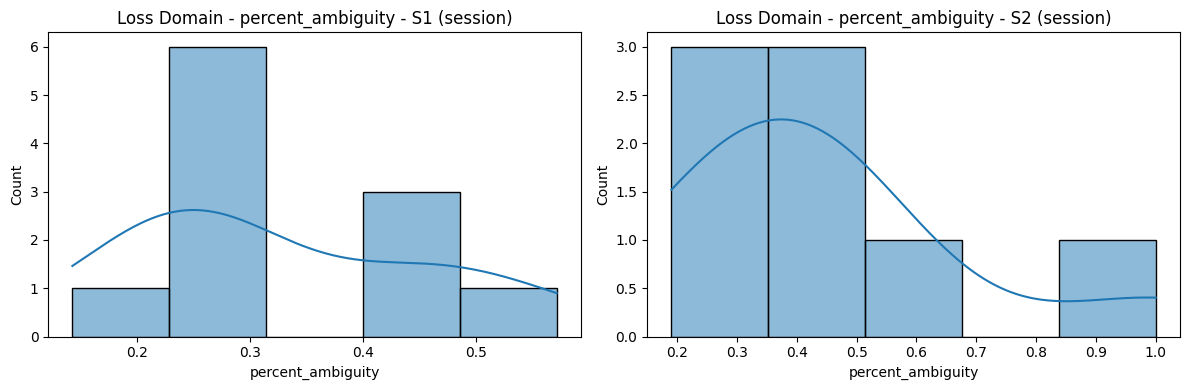

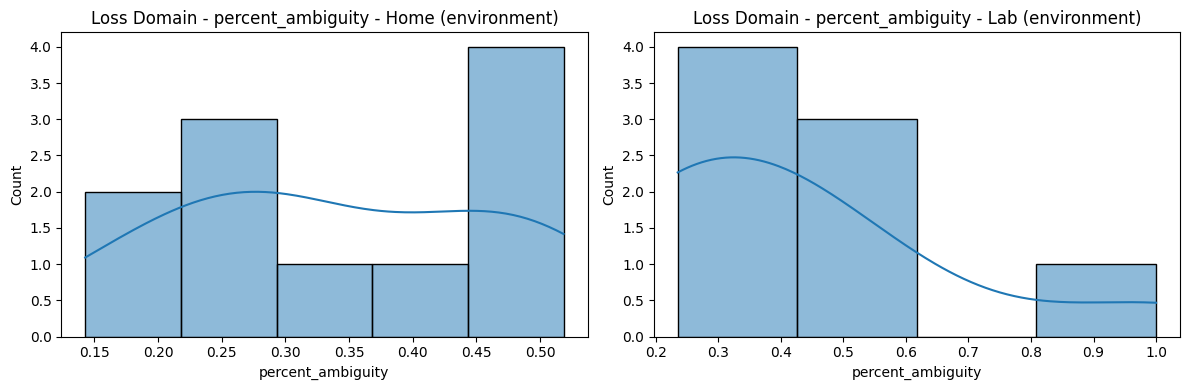

   Domain            Feature     Category            Test  Test Statistic  \
0    gain    percent_lottery      session          T-test        0.126322   
1    gain    percent_lottery  environment          T-test        0.673419   
2    gain       percent_risk      session          T-test       -0.015997   
3    gain       percent_risk  environment          T-test        0.904584   
4    gain  percent_ambiguity      session          T-test        0.271289   
5    gain  percent_ambiguity  environment          T-test        0.086275   
6    loss    percent_lottery      session          T-test       -1.103035   
7    loss    percent_lottery  environment          T-test       -0.789448   
8    loss       percent_risk      session          T-test       -0.909626   
9    loss       percent_risk  environment          T-test       -0.624743   
10   loss  percent_ambiguity      session          T-test       -1.361417   
11   loss  percent_ambiguity  environment  Mann-Whitney U       41.000000   

In [22]:
def assess_distributions_and_compare(dataframe):
    results = []
    numerical_features = ['percent_lottery', 'percent_risk', 'percent_ambiguity']
    domains = ['gain', 'loss']

    # Iterate over each domain and numerical feature
    for domain in domains:
        domain_data = dataframe[dataframe['domain'] == domain]

        for column in numerical_features:
            if column in domain_data.columns:
                # Iterate over the two categories: session and environment
                for category in ['session', 'environment']:
                    # Split the data by category within the domain
                    category_groups = domain_data.groupby(category)[column]

                    if len(category_groups) == 2:
                        data_groups = [group.dropna() for name, group in category_groups]
                        shapiro_tests = [stats.shapiro(data) for data in data_groups]

                        if all(p > 0.05 for stat, p in shapiro_tests):
                            test_stat, p_val = stats.ttest_ind(*data_groups)
                            test_name = 'T-test'
                        else:
                            test_stat, p_val = stats.mannwhitneyu(*data_groups)
                            test_name = 'Mann-Whitney U'

                        result = {
                            'Domain': domain,
                            'Feature': column,
                            'Category': category,
                            'Test': test_name,
                            'Test Statistic': test_stat,
                            'p-Value': p_val
                        }
                        results.append(result)

                        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                        for i, (name, group) in enumerate(category_groups):
                            sns.histplot(group, kde=True, ax=ax[i])
                            ax[i].set_title(f'{domain.capitalize()} Domain - {column} - {name} ({category})')
                        plt.tight_layout()
                        plt.show()
                    else:
                        print(f"Skipping {column}, as there are not exactly two groups in {category} for {domain} domain.")
            else:
                print(f"Skipping non-existent column: {column}")

    return pd.DataFrame(results)

# Example usage
df = new_crdm
distribution_results = assess_distributions_and_compare(df)
print(distribution_results)

In [23]:
def assess_distributions_and_compare(dataframe, pdf_filepath):
    results = []
    numerical_features = ['percent_lottery', 'percent_risk', 'percent_ambiguity']
    domains = ['gain', 'loss']

    # Initialize a PDF file for the plots
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filepath)

    # Iterate over each domain and numerical feature
    for domain in domains:
        domain_data = dataframe[dataframe['domain'] == domain]

        for column in numerical_features:
            if column in domain_data.columns:
                # Iterate over the two categories: session and environment
                for category in ['session', 'environment']:
                    # Split the data by category within the domain
                    category_groups = domain_data.groupby(category)[column]

                    if len(category_groups) == 2:
                        data_groups = [group.dropna() for name, group in category_groups]
                        shapiro_tests = [stats.shapiro(data) for data in data_groups]

                        if all(p > 0.05 for stat, p in shapiro_tests):
                            test_stat, p_val = stats.ttest_ind(*data_groups)
                            test_name = 'T-test'
                        else:
                            test_stat, p_val = stats.mannwhitneyu(*data_groups)
                            test_name = 'Mann-Whitney U'

                        result = {
                            'Domain': domain,
                            'Feature': column,
                            'Category': category,
                            'Test': test_name,
                            'Test Statistic': test_stat,
                            'p-Value': p_val
                        }
                        results.append(result)

                        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                        for i, (name, group) in enumerate(category_groups):
                            sns.histplot(group, kde=True, ax=ax[i])
                            ax[i].set_title(f'{domain.capitalize()} Domain - {column} - {name} ({category})')
                        plt.tight_layout()
                        pdf.savefig(fig)  # Save the current figure into the PDF
                        plt.close(fig)
                    else:
                        print(f"Skipping {column}, as there are not exactly two groups in {category} for {domain} domain.")
            else:
                print(f"Skipping non-existent column: {column}")

    # Close the PDF file
    pdf.close()

    return pd.DataFrame(results)

# Example usage
df = new_crdm  # Ensure new_crdm is the DataFrame you're working with
pdf_filepath = 'lottery_distributions_and_results.pdf'  # Replace with your desired path
distribution_results = assess_distributions_and_compare(df, pdf_filepath)
print(distribution_results)


   Domain            Feature     Category            Test  Test Statistic  \
0    gain    percent_lottery      session          T-test        0.126322   
1    gain    percent_lottery  environment          T-test        0.673419   
2    gain       percent_risk      session          T-test       -0.015997   
3    gain       percent_risk  environment          T-test        0.904584   
4    gain  percent_ambiguity      session          T-test        0.271289   
5    gain  percent_ambiguity  environment          T-test        0.086275   
6    loss    percent_lottery      session          T-test       -1.103035   
7    loss    percent_lottery  environment          T-test       -0.789448   
8    loss       percent_risk      session          T-test       -0.909626   
9    loss       percent_risk  environment          T-test       -0.624743   
10   loss  percent_ambiguity      session          T-test       -1.361417   
11   loss  percent_ambiguity  environment  Mann-Whitney U       41.000000   

In [24]:
def assess_distributions_and_compare(dataframe, pdf_filepath):
    results = []
    numerical_features = ['alpha', 'beta', 'gamma']
    domains = ['gain', 'loss']

    # Initialize a PDF file for the plots
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filepath)

    # Iterate over each domain and numerical feature
    for domain in domains:
        domain_data = dataframe[dataframe['domain'] == domain]

        for column in numerical_features:
            if column in domain_data.columns:
                # Iterate over the two categories: session and environment
                for category in ['session', 'environment']:
                    # Split the data by category within the domain
                    category_groups = domain_data.groupby(category)[column]

                    if len(category_groups) == 2:
                        data_groups = [group.dropna() for name, group in category_groups]
                        shapiro_tests = [stats.shapiro(data) for data in data_groups]

                        if all(p > 0.05 for stat, p in shapiro_tests):
                            test_stat, p_val = stats.ttest_ind(*data_groups)
                            test_name = 'T-test'
                        else:
                            test_stat, p_val = stats.mannwhitneyu(*data_groups)
                            test_name = 'Mann-Whitney U'

                        result = {
                            'Domain': domain,
                            'Feature': column,
                            'Category': category,
                            'Test': test_name,
                            'Test Statistic': test_stat,
                            'p-Value': p_val
                        }
                        results.append(result)

                        # Plotting logic
                        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
                        for i, (name, group) in enumerate(category_groups):
                            # Convert gamma values to natural log for plotting if the feature is 'gamma'
                            plot_data = np.log(group) if column == 'gamma' else group
                            sns.histplot(plot_data, kde=True, ax=ax[i])
                            title_suffix = ' (Natural Log)' if column == 'gamma' else ''
                            ax[i].set_title(f'{domain.capitalize()} Domain - {column}{title_suffix} - {name} ({category})')
                        plt.tight_layout()
                        pdf.savefig(fig)  # Save the current figure into the PDF
                        plt.close(fig)
                    else:
                        print(f"Skipping {column}, as there are not exactly two groups in {category} for {domain} domain.")
            else:
                print(f"Skipping non-existent column: {column}")

    # Close the PDF file
    pdf.close()

    return pd.DataFrame(results)


# Define your DataFrame 'df' here
df = new_crdm  # Ensure new_crdm is the DataFrame you're working with
pdf_filepath = 'distributions_and_results.pdf'  # Replace with your desired path
distribution_results = assess_distributions_and_compare(df, pdf_filepath)
print(distribution_results)

   Domain Feature     Category            Test  Test Statistic   p-Value
0    gain   alpha      session          T-test       -0.756443  0.459739
1    gain   alpha  environment          T-test        0.670095  0.511798
2    gain    beta      session          T-test        0.275066  0.786581
3    gain    beta  environment          T-test        0.320222  0.752702
4    gain   gamma      session          T-test       -1.516071  0.147875
5    gain   gamma  environment          T-test        1.020998  0.321566
6    loss   alpha      session          T-test        0.533338  0.600704
7    loss   alpha  environment          T-test        0.149474  0.882939
8    loss    beta      session  Mann-Whitney U       39.000000  0.716784
9    loss    beta  environment  Mann-Whitney U       30.000000  0.272287
10   loss   gamma      session          T-test       -1.500840  0.151741
11   loss   gamma  environment  Mann-Whitney U       43.000000  0.967849


plot distribution of all variables in session 1 and session 2, to assess for normal distribution
If they are, then a t-test can be done, if not then a non-parametric test can be run such as matt whitney
Later on, ICC Interclass correlation, data as groups, reliability, modern ICC, random effects model,
ICC will tell us, variance across people, variance where the mean of the population, noise between s2 and s1,
whatever variation you're seeing in s2 is seen across people but not significant
Test-re-test relaiability